## Load Libraries


In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os.path as op
import ssm
import itertools
import autograd.numpy as np
import matplotlib.pyplot as pltx
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.decomposition import PCA

np.set_printoptions(suppress=True)

import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

from tqdm.auto import tqdm
from pathlib import Path
from omegaconf import DictConfig, OmegaConf

import TiDHy
from TiDHy.utils.utils import *
from TiDHy.datasets import load_dataset
import TiDHy.utils.io_dict_to_hdf5 as ioh5
from TiDHy.Evaluate_TiDHy import run_seq_len_model

##### Plotting settings ######
import matplotlib as mpl
mpl.rcParams.update({'font.size':          10,
                     'axes.linewidth':     2,
                     'xtick.major.size':   5,
                     'ytick.major.size':   5,
                     'xtick.major.width':  2,
                     'ytick.major.width':  2,
                     'axes.spines.right':  False,
                     'axes.spines.top':    False,
                     'pdf.fonttype':       42,
                     'ps.fonttype':        42,
                     'xtick.labelsize':    10,
                     'ytick.labelsize':    10,
                     'figure.facecolor':   'white',
                     'pdf.use14corefonts': True,
                     'font.family':        'sans-serif',
                    #  'font.family':        'Arial',
                    #  'font.sans-serif':    'Arial',
                     'font.serif':         'Arial',
                    })

from matplotlib.colors import ListedColormap
clrs = ['#1A237E','#7E57C2','#757575','#BDBDBD','#4CAF50','#FF9800','#795548','#FF4081','#00BCD4','#FF1744','#FFFFFF','#000000']
cmap = ListedColormap(clrs)

device = torch.device(1) #torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

# Load SLDS Model

In [2]:
dataset = 'SLDS'
version = 'r2_orth_long'
# version = 'partial_obs'
base_dir = Path('/data/users/eabe/hypernets/{}/TiDHy_{}/{}'.format(dataset,dataset,version))
configs = sorted(list(base_dir.rglob('*config.yaml'))[::2])
fig_path = Path('/data/users/eabe/hypernets/SLDS/TiDHy_SLDS/r2_orth_long/Paper_Figs')
for n,conf in enumerate(configs):
    print(n,conf)

0 /data/users/eabe/hypernets/SLDS/TiDHy_SLDS/r2_orth_long/Orth_alpha_r2=5,dataset.ssm_params.seed=10,dataset.train.num_epochs=1500/config.yaml
1 /data/users/eabe/hypernets/SLDS/TiDHy_SLDS/r2_orth_long/Orth_alpha_r2=5,dataset.ssm_params.seed=11,dataset.train.num_epochs=1500/config.yaml
2 /data/users/eabe/hypernets/SLDS/TiDHy_SLDS/r2_orth_long/Orth_alpha_r2=5,dataset.ssm_params.seed=12,dataset.train.num_epochs=1500/config.yaml
3 /data/users/eabe/hypernets/SLDS/TiDHy_SLDS/r2_orth_long/Orth_alpha_r2=5,dataset.ssm_params.seed=13,dataset.train.num_epochs=1500/config.yaml
4 /data/users/eabe/hypernets/SLDS/TiDHy_SLDS/r2_orth_long/Orth_alpha_r2=5,dataset.ssm_params.seed=14,dataset.train.num_epochs=1500/config.yaml
5 /data/users/eabe/hypernets/SLDS/TiDHy_SLDS/r2_orth_long/Orth_alpha_r2=5,dataset.ssm_params.seed=15,dataset.train.num_epochs=1500/config.yaml
6 /data/users/eabe/hypernets/SLDS/TiDHy_SLDS/r2_orth_long/Orth_alpha_r2=5,dataset.ssm_params.seed=16,dataset.train.num_epochs=1500/config.yaml

In [3]:
n = 0
cfg_path =configs[n]# Path('/data/users/eabe/hypernets/SLDS/DPC_SLDS/TestingNoTempLearning/mix_dim=15/config.yaml')
default_model_config = '/home/eabe/Research/MyRepos/HyperNets/conf/dataset/model/default_model.yaml'
cfg = load_cfg(cfg_path, default_model_config)


In [4]:
data_dict, cfg = load_dataset(cfg)

# ##### Convert to float tensors #####
train_inputs = torch.tensor(data_dict['inputs_train']).float()
test_inputs = torch.tensor(data_dict['inputs_test']).float()
val_inputs = torch.tensor(data_dict['inputs_val']).float()

input_dim = test_inputs.shape[-1]
# test_inputs = test_inputs.unsqueeze(0)
# test_inputs = stack_data(test_inputs,cfg.train.sequence_length,overlap=cfg.train.sequence_length//cfg.train.overlap_factor)
test_inputs = test_inputs.reshape(-1, cfg.train.sequence_length, input_dim)
val_inputs = val_inputs.reshape(-1, cfg.train.sequence_length, input_dim)
# train_inputs = train_inputs.reshape(-1, cfg.train.sequence_length, input_dim)
# cfg.model.input_dim = input_dim



print(f'Our inputs have shape: {test_inputs.shape}')
cfg.model.input_dim = input_dim
test_dataset = torch.utils.data.TensorDataset(test_inputs)
train_dataset = torch.utils.data.TensorDataset(train_inputs)
val_dataset = torch.utils.data.TensorDataset(val_inputs)
# dataloader_train = torch.utils.data.DataLoader(train_dataset,batch_size=train_inputs.shape[0],pin_memory=True,shuffle=False,drop_last=True)
dataloader_test = torch.utils.data.DataLoader(test_dataset,batch_size=test_inputs.shape[0],pin_memory=True,shuffle=False,drop_last=True)
# dataloader_val = torch.utils.data.DataLoader(val_dataset,batch_size=val_inputs.shape[0],shuffle=False,pin_memory=True,drop_last=True)
# device = torch.device("cuda:{}".formt(cfg.train['gpu']) if torch.cuda.is_available() else "cpu")


Creating Dataset: SLDS
Setting seed: 10
Setting seed: 10
Setting seed: 10
x Timescales: {'0': -0.025, '1': -0.25, '2': -0.1, '3': -0.5, '4': -0.01, '5': -0.75}, z Timescales: [0.975, 0.975, 0.975]
Our inputs have shape: torch.Size([250, 200, 20])


In [5]:
##### Load weights and params #####
rerecord = False
cfg.model.batch_converge=False
epoch = 1000
model = TiDHy.TiDHy(cfg.model, device, show_progress=cfg.train.show_progress).to(device)
# set_seed(42)
load_path = cfg.paths.ckpt_dir/'best.pth.tar'
# load_path = sorted(list(cfg.paths.ckpt_dir.rglob('last_{}.pth.tar'.format(epoch))))[0]
data_load = torch.load(load_path,map_location=device)
model.load_state_dict(data_load['state_dict'])
model.to(device)
print('Loaded from {} epoch'.format(data_load['epoch']))
epoch = data_load['epoch']-1


# result_dict = load_results(model, dataloader_test, data_dict, device, cfg, epoch, rerecord=rerecord)

Loaded from 1501 epoch


/tmp/ipykernel_1763894/331685311.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_load = torch.load(load_path,map_location=device)


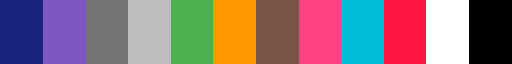

In [6]:
import matplotlib.gridspec as gridspec
fontsize=13

clrs = np.array(['#1A237E','#7E57C2','#757575','#BDBDBD','#4CAF50','#FF9800','#795548','#FF4081','#00BCD4','#FF1744','#FFFFFF','#000000'])
sys_clrs = ['#E3A19F','#E3BE53','#708090','#90CCA9','#B7522E','#B0E0E6','#A89AC2','#556B2F','#FF6F61','#87CEEB','#FFDAB9','#40E0D0']
cmap_sys = ListedColormap(sys_clrs)
clr_ind =[8,8,1,1,9,9]
# clr2 = [sys_clrs[clr_ind[n]] for n in range(len(clr_ind))]
clr_ind3 = [2,8,9]
clr2b = [sys_clrs[clr_ind3[n]] for n in range(len(clr_ind3))]

clrs_b = clrs[[0,1,2,9,4,6,7,8,11]]
cmap = ListedColormap(clrs)
# cmap_small = ListedColormap(clrs[:len(np.unique(full_state_z))])
cmap_b = ListedColormap(clrs_b)
cmap
# cmap_b

# Save Multi Seq Len

In [7]:
seq_len = [100,200,500,1000]

cfg, result_dict = run_seq_len_model(seq_len, model, data_dict, device, 1500, cfg, rerun=False)

data_dict, cfg = load_dataset(cfg)
seq_len = sorted([int(el) for el in list(result_dict.keys())])
seq_len

Creating Dataset: SLDS
Setting seed: 10
Setting seed: 10
Setting seed: 10
x Timescales: {'0': -0.025, '1': -0.25, '2': -0.1, '3': -0.5, '4': -0.01, '5': -0.75}, z Timescales: [0.975, 0.975, 0.975]


[100, 200, 500, 1000]

## Load Results

In [8]:

states_x_test = data_dict['states_x_test']
states_z_test = data_dict['states_z_test']
# states_z_test = data_dict['states_z']
ssm_params = cfg.dataset.ssm_params
##### Set up combinatorics of timescales #####
lst = list(itertools.product([1, 0], repeat=3))
lst2 = list(itertools.product(['F', 'S'], repeat=3))
full_state_z = np.zeros(ssm_params['time_bins_test'],dtype=int)
# full_state_z = np.zeros(ssm_params['time_bins_train'],dtype=int)
for n in range(len(lst)):
    full_state_z[np.apply_along_axis(lambda x: np.all(x == lst[n]),0,states_z_test)] = n


save_figs = False
p=-1
W = result_dict['{}'.format(seq_len[p])]['W'].reshape(-1,result_dict['{}'.format(seq_len[p])]['W'].shape[-1])
# b = result_dict['b'].reshape(-1,result_dict['b'].shape[-1])
I = result_dict['{}'.format(seq_len[p])]['I'].reshape(-1,result_dict['{}'.format(seq_len[p])]['I'].shape[-1])
Ihat = result_dict['{}'.format(seq_len[p])]['I_hat'].reshape(-1,result_dict['{}'.format(seq_len[p])]['I_hat'].shape[-1])
Ibar = result_dict['{}'.format(seq_len[p])]['I_bar'].reshape(-1,result_dict['{}'.format(seq_len[p])]['I_bar'].shape[-1])
R_hat = result_dict['{}'.format(seq_len[p])]['R_hat'].reshape(-1,result_dict['{}'.format(seq_len[p])]['R_hat'].shape[-1])
R_bar = result_dict['{}'.format(seq_len[p])]['R_bar'].reshape(-1,result_dict['{}'.format(seq_len[p])]['R_bar'].shape[-1])
R2_hat = result_dict['{}'.format(seq_len[p])]['R2_hat'].reshape(-1,result_dict['{}'.format(seq_len[p])]['R2_hat'].shape[-1])
# Ut = result_dict['Ut'].reshape(-1,result_dict['Ut'].shape[-2],result_dict['Ut'].shape[-1])
# ##### Plot dynamic matrices #####
if cfg.model.low_rank_temp:
    Uk = torch.bmm(model.temporal.unsqueeze(-1),model.temporal.unsqueeze(1)).data.cpu().detach()
else:
    Uk = model.temporal.data.cpu().detach().reshape(model.mix_dim,model.r_dim,model.r_dim)
    U_t = torch.matmul(torch.Tensor(W[:,None,:]), model.temporal.unsqueeze(0).cpu().detach()).reshape(-1, model.r_dim, model.r_dim).numpy()
As = np.stack([v for v in data_dict['As'].values()])
bs = np.stack([v for v in data_dict['bs'].values()])
nfig = 0
fontsize=13
# t = 0; dt = 5000

In [9]:
import pickle
from ssm.util import random_rotation, find_permutation
inputs_train_SLDS=data_dict['inputs_train']
inputs_test_SLDS=data_dict['inputs_test']
seed = cfg.dataset.ssm_params['seed']
# SLDS_path = Path('/data/users/eabe/hypernets/SLDS/TiDHy_SLDS/L1ShortWin/L1_alpha=0.001,dataset.ssm_params.seed=10,dataset.train.sequence_length=200')
SLDS_path = cfg.paths.log_dir#/'SSM/DPC_SSM/Benchmark/dataset.ssm_params.seed={}/'.format(seed)
N = inputs_train_SLDS.shape[-1]
K = len(np.unique(full_state_z))
D = data_dict['states_x_test'].shape[-1]
with open(SLDS_path/'ssm_slds_test_full_{}D_{}K_{}seed.pickle'.format(D,K,seed), 'rb') as handle:
# with open(cfg.paths.data_dir/'ssm_rslds_test.pickle', 'rb') as handle:
    slds = pickle.load(handle)
    posterior = pickle.load(handle)
    SLDS_latents = pickle.load(handle)
    SLDS_states = pickle.load(handle)
    SLDS_emission = pickle.load(handle)

with open(SLDS_path/'ssm_rslds_test_full_{}D_{}K_{}seed.pickle'.format(D,K,seed), 'rb') as handle:
# with open(cfg.paths.data_dir/'ssm_rslds_test.pickle', 'rb') as handle:
    slds = pickle.load(handle)
    posterior = pickle.load(handle)
    rSLDS_latents = pickle.load(handle)
    rSLDS_states = pickle.load(handle)
    rSLDS_emission = pickle.load(handle)


In [12]:
from sklearn.linear_model import RidgeClassifier,LogisticRegression, RidgeClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
# from statsmodels.tsa.api import VAR

nani = full_state_z.shape[0]
ts=-1
reg_variables = [
    result_dict['{}'.format(seq_len[ts])]['R2_hat'],
    result_dict['{}'.format(seq_len[ts])]['W'],
    result_dict['{}'.format(seq_len[ts])]['R_bar'],
    result_dict['{}'.format(seq_len[ts])]['R_hat'],
    result_dict['{}'.format(seq_len[ts])]['I'],
    SLDS_latents,]

labels = ['R2_hat','W','R_bar','R_hat','I','SLDS']
max_acc = 0
tr_batch_size = 40
batch_size = 10
for k,reg_vars in enumerate(reg_variables):
    X_train, X_test, y_train, y_test = train_test_split(reg_vars.reshape(-1,reg_vars.shape[-1]), full_state_z.reshape(-1), test_size=0.25, random_state=42)
    neigh = KNeighborsClassifier(n_neighbors=3,n_jobs=-1)
    neigh.fit(X_train, y_train)
    scores = neigh.score(X_test, y_test)
    print(labels[k],scores)
    if (scores > max_acc) & (labels[k] != 'I'):
        y_pred = neigh.predict(reg_vars.reshape(-1,reg_vars.shape[-1]))
        max_acc = scores
        best_reg_vars = reg_vars
        best_label = labels[k]
        best_pred = y_pred

state_compare = np.stack([rSLDS_states, SLDS_states,best_pred,full_state_z],axis=0)



R2_hat 0.81328
W 0.67856
R_bar 0.44144
R_hat 0.47768
I 0.45872
SLDS 0.4312


comp 0, cc: 0.996, ang: 5.31, ang_x:88.6, ang_r:77.0
comp 1, cc: 0.843, ang: 32.5, ang_x:79.1, ang_r:62.9
comp 0, cc: 0.974, ang: 13.1, ang_x:28.8, ang_r:88.8
comp 1, cc: 0.896, ang: 26.3, ang_x:29.1, ang_r:88.0
comp 0, cc: 1.0, ang: 1.29, ang_x:72.4, ang_r:1.49e+02
comp 1, cc: 0.571, ang: 55.2, ang_x:96.9, ang_r:57.7


/tmp/ipykernel_1763894/2841710559.py:119: UserWarning: You passed a edgecolor/edgecolors ('None') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=min_error_timescales,y=np.abs(evals_Uhat_all.reshape(-1)[min_error_idx]), marker='x',


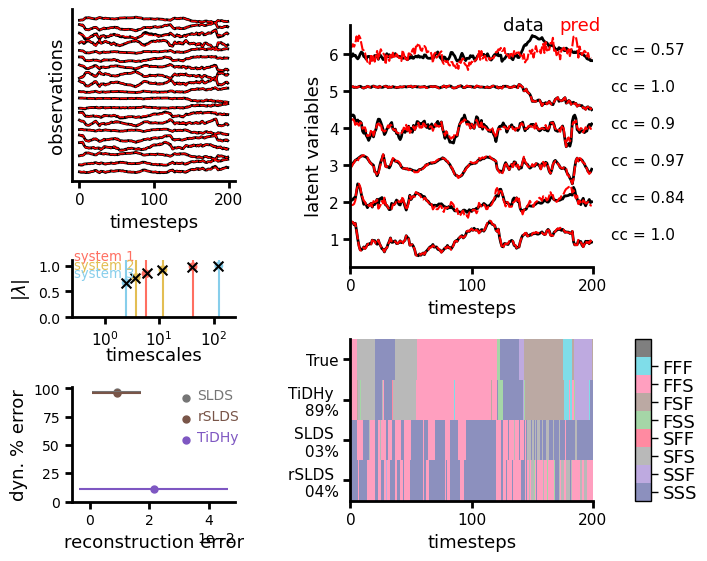

In [20]:
from sklearn.cross_decomposition import CCA
from sklearn.metrics import accuracy_score

n_comps=ssm_params['latent_dim']
t=1500; dt=200
    
fig = plt.figure(constrained_layout=True, figsize=(7,5.5))
gs0 = gridspec.GridSpec(nrows=5,ncols=4, figure=fig, wspace=.45,hspace=.2)

gs00 = gridspec.GridSpecFromSubplotSpec(nrows=6,ncols=1,subplot_spec=gs0[:,:2],wspace=.1,hspace=.2)
# gs01 = gridspec.GridSpecFromSubplotSpec(3,1, subplot_spec=gs0[0:,:1],wspace=.05,hspace=.8)
axs = np.array([fig.add_subplot(gs00[:-3,0]),
                fig.add_subplot(gs00[-3:-2,0]),
                fig.add_subplot(gs00[-2:,0]),
                fig.add_subplot(gs0[:3,2:]),
                fig.add_subplot(gs0[3:,2:])])
axs[4].sharex(axs[3])
ts = -1
##### Pannel a #####
I = result_dict['{}'.format(seq_len[ts])]['I'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I'].shape[-1])
Ihat = result_dict['{}'.format(seq_len[ts])]['I_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I_hat'].shape[-1])
# fig,axs = plt.subplots(1,2,figsize=(5,3),sharey=True,gridspec_kw={'wspace':.15,'width_ratios':[2,1]})
ax = axs[0]
spacing = 1
xrange = 100
cmap2,norm = map_discrete_cbar(cmap_b,len(np.unique(full_state_z)))
linestyle =  (0, (5, 1))#(0, (5, 5))
hlines_I,hlines_Ihat = [],[]
for n in range(I.shape[-1]):
    mean_centered_I = I[t:t+dt,n] - np.mean(I[t:t+dt,n],axis=0)
    ax.plot(mean_centered_I + n/spacing,color='k', lw=2,zorder=1,label='Data')
    hlines_I.append(np.mean(mean_centered_I + n/spacing,axis=0))
    mean_centered_Ihat = Ihat[t:t+dt,n] - np.mean(Ihat[t:t+dt,n],axis=0)
    ax.plot(mean_centered_Ihat + n/spacing, linestyle=linestyle, color='r', lw=1,zorder=2,label='Pred')
    hlines_Ihat.append(np.mean(mean_centered_Ihat + n/spacing,axis=0))

# ax.set_yticks(hlines_I)
ax.set_yticks([])
# ax.set_yticklabels(np.arange(1,len(hlines_I)+1),fontsize=fontsize-2)
ax.set_ylabel('observations',fontsize=fontsize)
ax.set_xticks(np.arange(0,dt+xrange,xrange))
ax.set_xticklabels(np.arange(0,dt+xrange,xrange),fontsize=fontsize-2)
ax.set_xlabel('timesteps',fontsize=fontsize)

##### Pannel c #####
ax = axs[3]
count=0
acc_slds = accuracy_score(full_state_z, SLDS_states)
acc_rslds = accuracy_score(full_state_z, rSLDS_states)
acc_TiDHy = accuracy_score(full_state_z, y_pred)
spacing = .5

hlines_x,hlines_Rhat = [],[]
for p in range(ssm_params['Nlds']):
    # states_x_cca = states_x_train[:,(ssm_params['latent_dim']*(p)):(p+1)*ssm_params['latent_dim']]
    states_x_cca = states_x_test[:,(ssm_params['latent_dim']*(p)):(p+1)*ssm_params['latent_dim']]
    # states_x_cca = states_x_test[:,p:p+1]
    cca = CCA(n_components=ssm_params['latent_dim'],max_iter=1000)
    X_c,Y_c = cca.fit_transform(states_x_cca,R_hat)
    cca_coefficient = np.corrcoef(X_c.T, Y_c.T).diagonal(offset=n_comps)
    x_w = cca.x_weights_
    y_w = cca.y_weights_
    cca_angles = [np.rad2deg(angle_between(X_c[:,n],Y_c[:,n])) for n in range(n_comps)]
    cca_angles_x = [np.rad2deg(angle_between(X_c[:,n],states_x_cca[:,n])) for n in range(n_comps)]
    cca_angles_r = [np.rad2deg(angle_between(Y_c[:,n],R_hat[:,n])) for n in range(n_comps)]
    for n in range(n_comps):
        print('comp {}, cc: {:.03}, ang: {:.03}, ang_x:{:.03}, ang_r:{:.03}'.format(n,cca_coefficient[n],cca_angles[n],cca_angles_x[n],cca_angles_r[n]))

    for i in range(X_c.shape[-1]):
        mean_centered_x = X_c[t:t+dt,i] - np.mean(X_c[t:t+dt,i],axis=0)
        mean_centered_x=mean_centered_x/(np.max(np.abs(mean_centered_x)))
        ax.plot(np.arange(0,dt),mean_centered_x + count/spacing,color='k', lw=2,zorder=1)
        hlines_x.append(np.mean(mean_centered_x + count/spacing,axis=0))
        mean_centered_Rhat = Y_c[t:t+dt,i] - np.mean(Y_c[t:t+dt,i],axis=0)
        mean_centered_Rhat=mean_centered_Rhat/(np.max(np.abs(mean_centered_Rhat)))
        ax.plot(np.arange(0,dt),mean_centered_Rhat + count/spacing,linestyle=linestyle,color='r', lw=1.5,zorder=2,label='$\hat{{r}}_{{{}}}$={:.02}'.format(n,cca_coefficient[n]),alpha=1)
        hlines_Rhat.append(np.mean(mean_centered_Rhat + count/spacing,axis=0))
        ax.text(x=dt+15,y=hlines_x[count],s='cc = {:.02}'.format(cca_coefficient[i]),fontsize=fontsize-2)
        count += 1
    ax.set_yticks(hlines_x) 
    ax.set_yticklabels(np.arange(1,len(hlines_x)+1),fontsize=fontsize-2)
    # ax.set_xlabel('Timesteps',fontsize=fontsize)
    ax.set_ylabel('latent variables',fontsize=fontsize)
# ax.set_xticks([])
ax.set_xticks(np.arange(0,dt+200,200))
ax.set_xticklabels(np.arange(0,dt+200,200),fontsize=fontsize-2)
ax.set_xlabel('timesteps', fontsize=fontsize)
# X,Y = np.meshgrid(np.arange(0,dt),np.arange(-1,2*6))
# im = ax.pcolormesh(X,Y,np.tile(full_state_z[None,t:t+dt],(2*6+1,1)),cmap=cmap,norm=norm,alpha=.5,rasterized=True,zorder=-1)
ax.legend(['data','pred'],frameon=False,fontsize=fontsize,loc='upper right',bbox_to_anchor=(1.1,1.1),labelcolor='linecolor',handlelength=0,handleheight=0,ncols=2,columnspacing=.1)

##### Pannel b #####
ax = axs[1]
dts = 1/len(np.unique(full_state_z))
y_ranges=np.repeat([[0,1]],3,axis=0)
timescales_As = 1/np.abs(np.real(np.log(np.linalg.eigvals(As)))[:,:,0].reshape(-1))
# timescales_As = 1/np.abs(np.log(np.real(np.linalg.eigvals(As)))[:,:,0].reshape(-1))
evals_As = np.linalg.eigvals(As)[:,:,0].reshape(-1)
R_bar = result_dict['{}'.format(seq_len[ts])]['R_bar'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_bar'].shape[-1])
R_hat = result_dict['{}'.format(seq_len[ts])]['R_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_hat'].shape[-1])
Uhat_all = []
for state in range(len(np.unique(full_state_z))):
    rhat2 = R_hat[np.where(full_state_z==state)[0],:]
    Uhat_0 = np.linalg.inv(rhat2[:-1].T@rhat2[:-1])@rhat2[:-1].T@rhat2[1:]
    Uhat_all.append(Uhat_0)
    
# for p in range(ssm_params.Nlds):
#     for state in range(ssm_params.n_disc_states):
#         rhat2 = R_hat[np.where(states_z_test[p]==state)[0],:]
#         Uhat_0 = np.linalg.inv(rhat2[:-1].T@rhat2[:-1])@rhat2[:-1].T@rhat2[1:]
#         Uhat_all.append(Uhat_0)
        
Uhat_all = np.stack(Uhat_all)
evals_Uhat_all = np.linalg.eigvals(Uhat_all).reshape(-1)
timescales = 1/np.abs(np.real(np.log(evals_Uhat_all)))
min_error_idx = np.array([np.argmin(np.abs(timescales.reshape(-1) - timescales_As.reshape(-1)[n])) for n in range(timescales_As.shape[0])])
min_error_timescales = timescales[min_error_idx]
# timescales = 1/np.abs(np.log(np.real(evals_Uhat_all)))
ax.scatter(x=min_error_timescales,y=np.abs(evals_Uhat_all.reshape(-1)[min_error_idx]), marker='x',
            c='k',s=50,alpha=1,edgecolor='None',zorder=3)
for n in range(len(timescales_As)):
    ax.axvline(x=timescales_As[n],c=sys_clrs[clr_ind[n]])
    ax.scatter(x=timescales_As[n],y=np.abs(evals_As[n]),
            c=sys_clrs[clr_ind[n]],s=40,alpha=1,edgecolor='None')
ax.set_xscale('symlog',linthresh=.1)
ax.set_yticks([0,.5,1])
ax.set_ylim(0,1.1)
ax.set_xlim(0.25,2.5e2)
# ax.set_yticks([np.diff(y_ranges)[0,0]/2 + q*dts for q in range(len(np.unique(full_state_z)))])
# ax.set_yticklabels([''.join(lst2[n]) for n in range(len(lst2))],fontsize=fontsize-2)
# ax.set_xticks([0,-10e0,-10e-1])
ax.tick_params(axis='x', labelsize=fontsize-2)
ax.set_ylabel('|$\lambda$|',fontsize=fontsize)
y = 1
dy = 0.15
ax.annotate('system 1', xy=(.01,y),xycoords='axes fraction',color=sys_clrs[clr_ind[0]],fontsize=fontsize-3.5)
ax.annotate('system 2', xy=(.01,y-dy),xycoords='axes fraction',color=sys_clrs[clr_ind[2]],fontsize=fontsize-3.5)
ax.annotate('system 3', xy=(.01,y-2*dy),xycoords='axes fraction',color=sys_clrs[clr_ind[4]],fontsize=fontsize-3.5)
# ax.set_xticks([0,-10e0,-10e-1])
ax.set_xlabel('timescales',fontsize=fontsize,labelpad=-1)

######### Accuracy and reconstruction error #########
ax = axs[2]
Input_Errors_SLDS = np.abs(inputs_test_SLDS-SLDS_emission)
Input_Errors_rSLDS = np.abs(inputs_test_SLDS-rSLDS_emission)
Input_Errors = np.abs(I-result_dict['{}'.format(seq_len[ts])]['I_hat'])
err_slds  = 100*(1-accuracy_score(full_state_z, SLDS_states))
err_rslds = 100*(1-accuracy_score(full_state_z, rSLDS_states))
err_TiDHy = 100*(1-accuracy_score(full_state_z, y_pred))
ax.scatter(x=np.mean(Input_Errors_SLDS),y=err_slds, s=25, c=clrs[2],label='SLDS')
ax.errorbar(x=np.mean(Input_Errors_SLDS),y=err_slds, ecolor=clrs[2],xerr=np.std(Input_Errors_SLDS))#/np.sqrt(len(Input_Errors_SLDS)))
ax.scatter(x=np.mean(Input_Errors_rSLDS),y=err_rslds, s=25,c=clrs[6],label='rSLDS')
ax.errorbar(x=np.mean(Input_Errors_rSLDS),y=err_rslds, ecolor=clrs[6],xerr=np.std(Input_Errors_rSLDS))#/np.sqrt(len(Input_Errors_SLDS)))
ax.scatter(x=np.mean(Input_Errors),y=err_TiDHy, s=25, c=clrs[1],label='TiDHy')
ax.errorbar(x=np.mean(Input_Errors),y=err_TiDHy, ecolor=clrs[1],xerr=np.std(Input_Errors))#/np.sqrt(len(Input_Errors_SLDS)))
ax.set_yticks([0,25,50,75,100])
ax.set_xlabel('reconstruction error',fontsize=fontsize)
ax.set_ylabel('dyn. % error',fontsize=fontsize)
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0),useLocale=True)
ax.legend(frameon=False,fontsize=fontsize-3,loc='upper right',bbox_to_anchor=(1.1,1.1),labelcolor='linecolor',handlelength=0,handleheight=0,ncols=1,columnspacing=.1)

##### Pannel d #####
ax = axs[4]
ylabels_states = ['rSLDS \n {:02}%'.format(int(np.round(acc_rslds*100))),
                  'SLDS \n {:02}%'.format(int(np.round(acc_slds*100))),
                  'TiDHy \n {:02}%'.format(int(np.round(acc_TiDHy*100))),
                  'True']
im = ax.pcolormesh(state_compare[:,t:t+dt],cmap=cmap2,norm=norm,alpha=.5,rasterized=True)
ax.set_xticks(np.arange(0,dt+xrange,xrange))
ax.set_xticklabels(np.arange(0,dt+xrange,xrange),fontsize=fontsize-2)
ax.set_yticks(np.arange(.5,4,1))
ax.set_yticklabels(ylabels_states,fontsize=fontsize-2)
ax.set_xlabel('timesteps',fontsize=fontsize)

cbar = fig.colorbar(im,ax=axs[-1],aspect=10, pad=-.2)

cbar.set_ticks(np.arange(0,len(np.unique(full_state_z)),1))
cbar.set_ticklabels([''.join(lst2[n]) for n in np.arange(len(lst2)-1,-1,-1)],fontsize=fontsize)
cbar.outline.set_linewidth(1)
cbar.minorticks_off()
cbar.ax.tick_params(width=1,which="major")
# fig.tight_layout()
# fig.savefig(cfg.paths.fig_dir/'Benchmark_Compare3.pdf',dpi=300)
fig.savefig(fig_path/'{}_Fig2_V2.pdf'.format(nfig),dpi=300, transparent=True)


In [67]:

nani = full_state_z.shape[0]
ts=1
best_pred_all = []
acc_ssm = accuracy_score(full_state_z, SLDS_states)
acc_TiDHy_all = []
for ts in range(len(seq_len)):
    reg_variables = [
        # np.concatenate([result_dict['{}'.format(seq_len[ts])]['R2_hat'],result_dict['{}'.format(seq_len[ts])]['W']],axis=-1)
        result_dict['{}'.format(seq_len[ts])]['R2_hat'],
        # q_lem_x,
        ]

    labels = ['R2_hat']
    # reg_variables = W
    max_acc = 0
    for k,reg_vars in enumerate(reg_variables):
        X_train, X_test, y_train, y_test = train_test_split(reg_vars.reshape(-1,reg_vars.shape[-1]), full_state_z.reshape(-1), test_size=0.25, random_state=42)
        neigh = KNeighborsClassifier(n_neighbors=3,n_jobs=-1)
        neigh.fit(X_train, y_train)
        scores = neigh.score(X_test, y_test)
        y_pred = neigh.predict(reg_vars.reshape(-1,reg_vars.shape[-1]))
        print(labels[k],scores)
        acc_TiDHy = accuracy_score(full_state_z, y_pred)
        acc_TiDHy_all.append(acc_TiDHy)
        best_pred_all.append(y_pred)

state_compare = np.concatenate([SLDS_states[None,:],np.stack(best_pred_all),full_state_z[None,:]],axis=0)



R2_hat 0.84072
R2_hat 0.84128
R2_hat 0.804
R2_hat 0.80072


## Load multi-seed

In [29]:
seq_len = [100,200,500,1000]

result_dict_all = {}
for n in range(len(configs)):
    cfg_path =configs[n]# Path('/data/users/eabe/hypernets/SLDS/DPC_SLDS/TestingNoTempLearning/mix_dim=15/config.yaml')
    default_model_config = '/home/eabe/Research/MyRepos/HyperNets/conf/dataset/model/default_model.yaml'
    cfg = load_cfg(cfg_path, default_model_config)
    cfg, result_dict = run_seq_len_model(seq_len, model, data_dict, device, 1500, cfg, rerun=False)
    result_dict_all['seed_{}'.format(cfg.dataset.ssm_params.seed)] = result_dict

In [30]:
# Default values
seeds = np.arange(10,10+len(configs))
seed = 10
ts = 200

##### Set up combinatorics of timescales #####
ssm_params = cfg.dataset.ssm_params
lst = list(itertools.product([0, 1], repeat=3))
lst2 = list(itertools.product(['F', 'S'], repeat=3))
full_state_z = np.zeros((len(seeds),ssm_params['time_bins_test']),dtype=int)
# full_state_z = np.zeros(ssm_params['time_bins_train'],dtype=int)
for i, seed in enumerate(seeds):
    for n in range(len(lst)):
        full_state_z[i,np.apply_along_axis(lambda x: np.all(x == lst[n]),0,result_dict_all[f'seed_{seed}'][f'{ts}']['states_z_test'])] = n
    
I_all = np.stack([result_dict_all[f'seed_{seed}'][f'{ts}']['I'] for seed in seeds])
I_hat_all = np.stack([result_dict_all[f'seed_{seed}'][f'{ts}']['I_hat'] for seed in seeds])
R2_hat_all = np.stack([np.stack([result_dict_all[f'seed_{seed}'][f'{ts}']['R2_hat'] for ts in seq_len])for seed in seeds])  # (n_seeds, Time, Z_dim)
R_bar_all = np.stack([np.stack([result_dict_all[f'seed_{seed}'][f'{ts}']['R_bar'] for ts in seq_len]) for seed in seeds])   # (n_seeds, TempWinN, Time, r2_dim)
R_hat_all = np.stack([np.stack([result_dict_all[f'seed_{seed}'][f'{ts}']['R_hat'] for ts in seq_len]) for seed in seeds])   # (n_seeds, TempWinN, Time, r_dim)
W_all = np.stack([np.stack([result_dict_all[f'seed_{seed}'][f'{ts}']['W'] for ts in seq_len]) for seed in seeds])           # (n_seeds, TempWinN, Time, r_dim)
As_all = np.stack([np.stack([v for v in result_dict_all[f'seed_{seed}'][f'{ts}']['As'].values()]) for seed in seeds])
result_dict_all[f'seed_{seed}'][f'{ts}'].keys()

dict_keys(['As', 'I', 'I_bar', 'I_hat', 'R2_hat', 'R_bar', 'R_hat', 'Ut', 'W', 'bs', 'spatial_loss_rbar', 'spatial_loss_rhat', 'states_x_test', 'states_x_train', 'states_z_test', 'states_z_train', 'temp_loss'])

In [31]:
import pickle
from ssm.util import random_rotation, find_permutation
inputs_train_SLDS=data_dict['inputs_train']
inputs_test_SLDS=data_dict['inputs_test']
seed = cfg.dataset.ssm_params['seed']
TotalTime = cfg.dataset.ssm_params.time_bins_test
# SLDS_path = Path('/data/users/eabe/hypernets/SLDS/TiDHy_SLDS/L1ShortWin/L1_alpha=0.001,dataset.ssm_params.seed=10,dataset.train.sequence_length=200')
N = inputs_train_SLDS.shape[-1]
K = len(np.unique(full_state_z))
D = data_dict['states_x_test'].shape[-1]
SLDS_latents = np.zeros((len(seeds),TotalTime,D))
SLDS_states = np.zeros((len(seeds),TotalTime))
SLDS_emission = np.zeros((len(seeds),TotalTime,N))
rSLDS_latents = np.zeros((len(seeds),TotalTime,D))
rSLDS_states = np.zeros((len(seeds),TotalTime))
rSLDS_emission = np.zeros((len(seeds),TotalTime,N))
for k, seed in enumerate(seeds):
    SLDS_path = configs[k].parent#/'SSM/DPC_SSM/Benchmark/dataset.ssm_params.seed={}/'.format(seed)
    with open(SLDS_path/'ssm_slds_test_full_{}D_{}K_{}seed.pickle'.format(D,K,seed), 'rb') as handle:
    # with open(cfg.paths.data_dir/'ssm_rslds_test.pickle', 'rb') as handle:
        slds = pickle.load(handle)
        posterior = pickle.load(handle)
        SLDS_latents[k] = pickle.load(handle)
        SLDS_states[k] = pickle.load(handle)
        SLDS_emission[k] = pickle.load(handle)

    with open(SLDS_path/'ssm_rslds_test_full_{}D_{}K_{}seed.pickle'.format(D,K,seed), 'rb') as handle:
    # with open(cfg.paths.data_dir/'ssm_rslds_test.pickle', 'rb') as handle:
        slds = pickle.load(handle)
        posterior = pickle.load(handle)
        rSLDS_latents[k] = pickle.load(handle)
        rSLDS_states[k] = pickle.load(handle)
        rSLDS_emission[k] = pickle.load(handle)


In [32]:
from sklearn.linear_model import RidgeClassifier,LogisticRegression, RidgeClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
# from statsmodels.tsa.api import VAR

nani = full_state_z.shape[0]
ts=-1

labels = seeds
max_acc = 0
tr_batch_size = 40
batch_size = 10
scores_all = []
pred_all = np.zeros((len(seeds),len(seq_len),cfg.dataset.ssm_params.time_bins_test))
for k in range(len(seeds)):
    for ts in range(len(seq_len)):
        X_train, X_test, y_train, y_test = train_test_split(R2_hat_all[k,ts], full_state_z[k].reshape(-1), test_size=0.25, random_state=42)
        neigh = KNeighborsClassifier(n_neighbors=3,n_jobs=-1)
        neigh.fit(X_train, y_train)
        scores = neigh.score(X_test, y_test)
        y_pred = neigh.predict(R2_hat_all[k,ts])
        pred_all[k,ts] = y_pred
        scores_all.append(accuracy_score(full_state_z[k].reshape(-1),y_pred))
        print(labels[k],seq_len[ts],scores)
        if (scores > max_acc) & (labels[k] != 'I'):
            max_acc = scores
            best_label = k
            best_pred = y_pred

# state_compare = np.stack([rSLDS_states, SLDS_states,best_pred,full_state_z[best_label]],axis=0)

scores_all = np.stack(scores_all).reshape(len(seeds),len(seq_len))

10 100 0.74264
10 200 0.7784
10 500 0.822
10 1000 0.81432
11 100 0.77832
11 200 0.80408
11 500 0.78976
11 1000 0.71128
12 100 0.59736
12 200 0.66512
12 500 0.71944
12 1000 0.6888
13 100 0.72656
13 200 0.78552
13 500 0.76368
13 1000 0.72504
14 100 0.69992
14 200 0.72824
14 500 0.75552
14 1000 0.7352
15 100 0.77504
15 200 0.79856
15 500 0.80384
15 1000 0.7964
16 100 0.59352
16 200 0.69376
16 500 0.75872
16 1000 0.70312
17 100 0.72904
17 200 0.76832
17 500 0.7812
17 1000 0.76216


/tmp/ipykernel_1737070/745072473.py:76: UserWarning: You passed a edgecolor/edgecolors ('None') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=min_error_timescales,y=np.abs(evals_Uhat_all.reshape(-1)[min_error_idx])+ts,
/tmp/ipykernel_1737070/745072473.py:76: UserWarning: You passed a edgecolor/edgecolors ('None') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=min_error_timescales,y=np.abs(evals_Uhat_all.reshape(-1)[min_error_idx])+ts,
/tmp/ipykernel_1737070/745072473.py:76: UserWarning: You passed a edgecolor/edgecolors ('None') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=min_error_timescales,y=np.abs(evals_Uhat_all.reshape(-1)[min_error_idx])+ts,
/tmp/ipykernel_1737070/74507

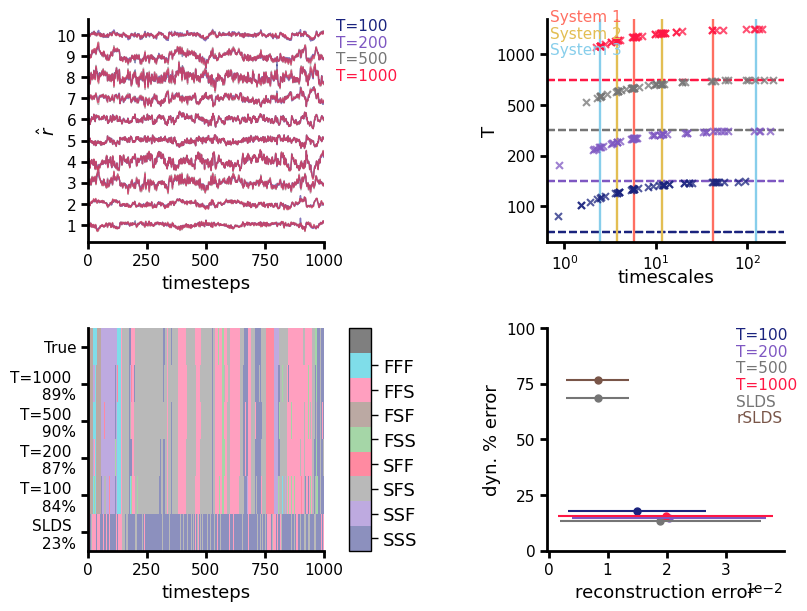

In [35]:
fig = plt.figure(constrained_layout=True, figsize=(8,6))
gs0 = gridspec.GridSpec(nrows=4,ncols=2, figure=fig, wspace=.15,hspace=.2)
axs = np.array([fig.add_subplot(gs0[:2,0]),fig.add_subplot(gs0[2:,0]),fig.add_subplot(gs0[:2,1]),fig.add_subplot(gs0[2:,1])])
t=1500; dt=1000
# seq_len=[100,200,500]
ts = 1
Input_Errors_SLDS = (I_all[k]-SLDS_emission[k])
ax = axs[-1]
Input_Errors_SLDS = np.mean([np.abs(I_all[k]-SLDS_emission[k]) for k in range(len(seeds))],axis=-1)
Input_Errors_rSLDS = np.mean([np.abs(I_all[k]-rSLDS_emission[k]) for k in range(len(seeds))],axis=-1)
err_slds  = np.mean([100*(1-accuracy_score(full_state_z[k], SLDS_states[k])) for k in range(len(seeds))])
err_rslds = np.mean([100*(1-accuracy_score(full_state_z[k], rSLDS_states[k])) for k in range(len(seeds))])
for ts in range(len(seq_len)):
    Input_Errors =np.stack([np.abs(I_all[seed,ts]-I_hat_all[seed,ts]) for seed in range(len(seeds))])
    err_TiDHy = np.mean([100*(1-accuracy_score(full_state_z[k], pred_all[k,ts])) for k in range(len(seeds))])
    ax.scatter(x=np.mean(Input_Errors),y=err_TiDHy, s=25, c=clrs_b[ts],label='TiDHy')
    ax.errorbar(x=np.mean(Input_Errors),y=err_TiDHy, ecolor=clrs_b[ts],xerr=np.mean(np.std(Input_Errors,axis=-1)),yerr=np.mean(np.std(Input_Errors,axis=0)))#/np.sqrt(len(Input_Errors_SLDS)))

ax.scatter(x=np.mean(Input_Errors_SLDS),y=err_slds, s=25, c=clrs[2],label='SLDS')
ax.errorbar(x=np.mean(Input_Errors_SLDS),y=err_slds, ecolor=clrs[2],xerr=np.std(Input_Errors_SLDS))#/np.sqrt(len(Input_Errors_SLDS)))
ax.scatter(x=np.mean(Input_Errors_rSLDS),y=np.mean(err_rslds), s=25,c=clrs[6],label='rSLDS')
ax.errorbar(x=np.mean(Input_Errors_rSLDS),y=np.mean(err_rslds), ecolor=clrs[6],xerr=np.std(Input_Errors_rSLDS))#/np.sqrt(len(Input_Errors_SLDS)))
ax.set_yticks([0,25,50,75,100])
ax.set_xlabel('reconstruction error',fontsize=fontsize)
ax.set_ylabel('dyn. % error',fontsize=fontsize)
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0),useLocale=True)
ax.tick_params(axis='x', labelsize=fontsize-2)
ax.tick_params(axis='y', labelsize=fontsize-2)
y = .95
dy = 0.075
for tts in range(len(seq_len)):
    ax.annotate('T={}'.format(seq_len[tts]), xy=(.8,y-tts*dy),xycoords='axes fraction',color=clrs_b[tts],fontsize=fontsize-2)
tts+=1
ax.annotate('SLDS', xy=(.8,y-tts*dy),xycoords='axes fraction',color=clrs[2],fontsize=fontsize-2)
tts += 1
ax.annotate('rSLDS', xy=(.8,y-tts*dy),xycoords='axes fraction',color=clrs[6],fontsize=fontsize-2)


states_z_test = data_dict['states_z_test']
ax = axs[2]
As = np.stack([v for v in data_dict['As'].values()])
timescales_As = 1/np.abs(np.real(np.log(np.linalg.eigvals(As)))[:,:,0].reshape(-1))
# timescales_As = 1/np.abs(np.log(np.real(np.linalg.eigvals(As)))[:,:,0].reshape(-1))
ts = 0
dts = 1/len(seq_len)
y_ranges = np.arange(0,1,(dts*dts)).reshape(-1,len(seq_len))[:,(0,-1)]
for ts in range(len(seq_len)):
    for seed in seeds: 
        R_bar = result_dict_all['seed_{}'.format(seed)]['{}'.format(seq_len[ts])]['R_bar'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_bar'].shape[-1])
        R_hat = result_dict_all['seed_{}'.format(seed)]['{}'.format(seq_len[ts])]['R_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_hat'].shape[-1])

        ##### Plottign Eigenvalues #####
        Uhat_all = []
        for state in range(len(np.unique(full_state_z[0]))):
            # rhat2 = R_hat[np.where(full_state_z==state)[0],:]
            # model = VAR(rhat2)
            # results = model.fit(maxlags=20,ic='aic')
            # eig_Ut = np.linalg.eigvals(results.coefs).reshape(-1)
            # Uhat_all.append(eig_Ut.reshape(-1))
        # for p in range(ssm_params.Nlds):
        #     for state in range(ssm_params.n_disc_states):
                # rhat2 = R_hat[np.where(states_z_test[p]==state)[0],:]
            rhat2 = R_hat[np.where(full_state_z[0]==state)[0],:]
            Uhat_0 = np.linalg.inv(rhat2[:-1].T@rhat2[:-1])@rhat2[:-1].T@rhat2[1:]
            Uhat_all.append(Uhat_0)

        Uhat_all = np.stack(Uhat_all)
        # evals_Uhat_all = np.hstack(Uhat_all)
        # timescales = 1/np.abs(np.log(np.real(evals_Uhat_all)))
        # timescales = np.real(np.log(Uhat_all))
        evals_Uhat_all = np.linalg.eigvals(Uhat_all).reshape(-1)
        timescales = 1/np.abs(np.real(np.log(evals_Uhat_all)))
        # timescales = 1/np.abs(np.log(np.real(evals_Uhat_all)))
        min_error_idx = np.array([np.argmin(np.abs(timescales.reshape(-1) - timescales_As.reshape(-1)[n])) for n in range(timescales_As.shape[0])])
        min_error_timescales = timescales[min_error_idx]
        ax.scatter(x=min_error_timescales,y=np.abs(evals_Uhat_all.reshape(-1)[min_error_idx])+ts,
                c=clrs_b[ts],alpha=.75,edgecolor='None',marker='x',s=25,zorder=3)

    for n in range(len(timescales_As)):
        ax.axvline(x=timescales_As[n],c=sys_clrs[clr_ind[n]])
        ax.axhline(y=ts,c=clrs_b[ts],linestyle='--',zorder=-1)
    # ax = plot_hist(timescales,-1.75,.1,.1,ax,'TiDHy',clr=clrs_b[ts])
    ax.set_xscale('symlog',linthresh=.1)
    ax.set_yticks([1/2 + q for q in range(len(seq_len))])
    ax.set_yticklabels(seq_len,fontsize=fontsize-2)
    ax.set_ylabel('T',fontsize=fontsize,labelpad=-2)
    # ax.spines.left.set_visible(False)
    ax.set_xlabel('timescales',fontsize=fontsize,labelpad=-3)
# ax.set_xticks([0,-10e0,-10e-1])
ax.tick_params(axis='x', labelsize=fontsize-2)
ax.set_xscale('symlog',linthresh=.015)
y = .99
dy = 0.075
ax.annotate('System 1', xy=(.01,y),xycoords='axes fraction',color=sys_clrs[clr_ind[0]],fontsize=fontsize-2)
ax.annotate('System 2', xy=(.01,y-dy),xycoords='axes fraction',color=sys_clrs[clr_ind[2]],fontsize=fontsize-2)
ax.annotate('System 3', xy=(.01,y-2*dy),xycoords='axes fraction',color=sys_clrs[clr_ind[4]],fontsize=fontsize-2)

ax=axs[0]
spacing= 5
for p in range(len(seq_len)):
    hlines_x = []
    for n in range(result_dict['{}'.format(seq_len[p])]['R_hat'].shape[-1]):
        trace = result_dict['{}'.format(seq_len[p])]['R_hat'][t:t+dt,n]
        mean_centered_x = trace - np.mean(trace,axis=0)
        ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c=clrs_b[p],alpha=.5)
        hlines_x.append(np.mean(mean_centered_x + n/spacing,axis=0))
ax.set_ylabel('$\hat{r}$',fontsize=fontsize,labelpad=-2)
ax.set_xlabel('timesteps',fontsize=fontsize)
ax.set_xticks(np.arange(0,dt+(dt//4),(dt)//4))
ax.set_xticklabels(np.arange(0,dt+(dt//4),(dt)//4),fontsize=fontsize-2)
ax.set_yticks(hlines_x)
ax.set_yticklabels(np.arange(1,len(hlines_x)+1),fontsize=fontsize-2)
ax.set_xlim([0,dt])
y = .95
dy = 0.075
for tts in range(len(seq_len)):
    ax.annotate('T={}'.format(seq_len[tts]), xy=(1.05,y-tts*dy),xycoords='axes fraction',color=clrs_b[tts],fontsize=fontsize-2)

# legend = ax.legend(['T={}'.format(seq_len[p]) for p in range(len(seq_len))],frameon=False,fontsize=fontsize,loc='upper right',
#           bbox_to_anchor=(1.25,1),labelcolor=clrs_b,handlelength=0,handleheight=0,ncols=1)


ax = axs[1]
state_compare = np.concatenate([SLDS_states[:1,:],pred_all[0],full_state_z[:1,:]],axis=0)
cmap2,norm = map_discrete_cbar(cmap_b,len(np.unique(full_state_z[0])))
acc_slds = accuracy_score(full_state_z[0], SLDS_states[0])
TiDHy_acc = ['T={} \n {:02}%'.format(seq_len[n],int(np.round(scores_all[0,n]*100))) for n in range(len(scores_all[0]))]
Ylabels = ['SLDS \n {:02}%'.format(int(np.round(acc_slds*100)))] + TiDHy_acc + ['True']  
im = ax.pcolormesh(state_compare[:,t:t+dt],cmap=cmap2,norm=norm,alpha=.5,rasterized=True)
# ax.set_xticks(np.arange(0,dt+200,200))
# ax.set_xticklabels(np.arange(0,dt+200,200),fontsize=fontsize)
ax.set_xticks(np.arange(0,dt+(dt//4),(dt)//4))
ax.set_xticklabels(np.arange(0,dt+(dt//4),(dt)//4),fontsize=fontsize-2)
ax.set_yticks(np.arange(.5,len(Ylabels),1))
ax.set_yticklabels(Ylabels,fontsize=fontsize-2)
ax.set_xlabel('timesteps',fontsize=fontsize)

cbar = fig.colorbar(im,ax=ax,aspect=10, pad=-.2)
cbar.set_ticks(np.arange(0,len(np.unique(full_state_z)),1))
cbar.set_ticklabels([''.join(lst2[n]) for n in np.arange(len(lst2)-1,-1,-1)],fontsize=fontsize)
cbar.outline.set_linewidth(1)
cbar.minorticks_off()
cbar.ax.tick_params(width=1,which="major")
fig.savefig(fig_path/'{}_Fig3.pdf'.format(0),dpi=300)


In [ ]:
ts = 1
Input_Errors = np.abs(I-result_dict['{}'.format(seq_len[ts])]['I_hat'])
np.mean(Input_Errors),np.std(Input_Errors)

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(8,6))
gs0 = gridspec.GridSpec(nrows=4,ncols=2, figure=fig, wspace=.15,hspace=.2)
axs = np.array([fig.add_subplot(gs0[:2,0]),fig.add_subplot(gs0[2:,0]),fig.add_subplot(gs0[:2,1]),fig.add_subplot(gs0[2:,1])])
t=1500; dt=1000
# seq_len=[100,200,500]

Input_Errors_SLDS = (inputs_test_SLDS-SLDS_emission)
ax = axs[0]
Input_Errors_SLDS = np.abs(inputs_test_SLDS-SLDS_emission)
Input_Errors_rSLDS = np.abs(inputs_test_SLDS-rSLDS_emission)
err_slds  = 100*(1-accuracy_score(full_state_z, SLDS_states))
err_rslds = 100*(1-accuracy_score(full_state_z, rSLDS_states))
for ts in range(len(seq_len)):
    Input_Errors = np.abs(I-result_dict['{}'.format(seq_len[ts])]['I_hat'])
    err_TiDHy = 100*(1-accuracy_score(full_state_z, y_pred))
    ax.scatter(x=np.mean(Input_Errors),y=err_TiDHy, s=25, c=clrs_b[ts],label='TiDHy')
    ax.errorbar(x=np.mean(Input_Errors),y=err_TiDHy, ecolor=clrs_b[ts],xerr=np.std(Input_Errors))#/np.sqrt(len(Input_Errors_SLDS)))

ax.scatter(x=np.mean(Input_Errors_SLDS),y=err_slds, s=25, c=clrs[2],label='SLDS')
ax.errorbar(x=np.mean(Input_Errors_SLDS),y=err_slds, ecolor=clrs[2],xerr=np.std(Input_Errors_SLDS))#/np.sqrt(len(Input_Errors_SLDS)))
ax.scatter(x=np.mean(Input_Errors_rSLDS),y=err_rslds, s=25,c=clrs[6],label='rSLDS')
ax.errorbar(x=np.mean(Input_Errors_rSLDS),y=err_rslds, ecolor=clrs[6],xerr=np.std(Input_Errors_rSLDS))#/np.sqrt(len(Input_Errors_SLDS)))
ax.set_yticks([0,25,50,75,100])
ax.set_xlabel('reconstruction error',fontsize=fontsize)
ax.set_ylabel('dyn. % error',fontsize=fontsize)
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0),useLocale=True)
ax.tick_params(axis='x', labelsize=fontsize-2)
ax.tick_params(axis='y', labelsize=fontsize-2)
y = .95
dy = 0.075
for tts in range(len(seq_len)):
    ax.annotate('T={}'.format(seq_len[tts]), xy=(.8,y-tts*dy),xycoords='axes fraction',color=clrs_b[tts],fontsize=fontsize-2)
tts+=1
ax.annotate('SLDS', xy=(.8,y-tts*dy),xycoords='axes fraction',color=clrs[2],fontsize=fontsize-2)
tts += 1
ax.annotate('rSLDS', xy=(.8,y-tts*dy),xycoords='axes fraction',color=clrs[6],fontsize=fontsize-2)


states_z_test = data_dict['states_z_test']
ax = axs[1]
As = np.stack([v for v in data_dict['As'].values()])
timescales_As = 1/np.abs(np.real(np.log(np.linalg.eigvals(As)))[:,:,0].reshape(-1))
ts = 0
dts = 1/len(seq_len)
y_ranges = np.arange(0,1,(dts*dts)).reshape(-1,len(seq_len))[:,(0,-1)]
for ts in range(len(seq_len)):
    R_bar = result_dict['{}'.format(seq_len[ts])]['R_bar'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_bar'].shape[-1])
    R_hat = result_dict['{}'.format(seq_len[ts])]['R_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_hat'].shape[-1])

    ##### Plottign Eigenvalues #####
    Uhat_all = []
    for state in range(len(np.unique(full_state_z))):
        # rhat2 = R_hat[np.where(full_state_z==state)[0],:]
        # model = VAR(rhat2)
        # results = model.fit(maxlags=20,ic='aic')
        # eig_Ut = np.linalg.eigvals(results.coefs).reshape(-1)
        # Uhat_all.append(eig_Ut.reshape(-1))
    # for p in range(ssm_params.Nlds):
    #     for state in range(ssm_params.n_disc_states):
            # rhat2 = R_hat[np.where(states_z_test[p]==state)[0],:]
        rhat2 = R_hat[np.where(full_state_z==state)[0],:]
        Uhat_0 = np.linalg.inv(rhat2[:-1].T@rhat2[:-1])@rhat2[:-1].T@rhat2[1:]
        Uhat_all.append(Uhat_0)

    Uhat_all = np.stack(Uhat_all)
    # evals_Uhat_all = np.hstack(Uhat_all)
    # timescales = 1/np.abs(np.log(np.real(evals_Uhat_all)))
    # timescales = np.real(np.log(Uhat_all))
    evals_Uhat_all = np.linalg.eigvals(Uhat_all).reshape(-1)
    timescales = 1/np.abs(np.real(np.log(evals_Uhat_all)))
    
    ax.scatter(x=timescales,y=np.abs(evals_Uhat_all)+ts,
               c=clrs_b[ts],alpha=.75,edgecolor='None',s=25)

    for n in range(len(timescales_As)):
        ax.axvline(x=timescales_As[n],c=sys_clrs[clr_ind[n]])
        ax.axhline(y=ts,c=clrs_b[ts],linestyle='--',zorder=-1)
    # ax = plot_hist(timescales,-1.75,.1,.1,ax,'TiDHy',clr=clrs_b[ts])
    ax.set_xscale('symlog',linthresh=.1)
    ax.set_yticks([1/2 + q for q in range(len(seq_len))])
    ax.set_yticklabels(seq_len,fontsize=fontsize-2)
    ax.set_ylabel('T',fontsize=fontsize,labelpad=-2)
    # ax.spines.left.set_visible(False)
    ax.set_xlabel('timescales',fontsize=fontsize,labelpad=-3)
# ax.set_xticks([0,-10e0,-10e-1])
ax.tick_params(axis='x', labelsize=fontsize-2)
ax.set_xscale('symlog',linthresh=.015)
y = .99
dy = 0.075
ax.annotate('System 1', xy=(.01,y),xycoords='axes fraction',color=sys_clrs[clr_ind[0]],fontsize=fontsize-2)
ax.annotate('System 2', xy=(.01,y-dy),xycoords='axes fraction',color=sys_clrs[clr_ind[2]],fontsize=fontsize-2)
ax.annotate('System 3', xy=(.01,y-2*dy),xycoords='axes fraction',color=sys_clrs[clr_ind[4]],fontsize=fontsize-2)

ax=axs[2]
spacing= 5
for p in range(len(seq_len)):
    hlines_x = []
    for n in range(result_dict['{}'.format(seq_len[p])]['R_hat'].shape[-1]):
        trace = result_dict['{}'.format(seq_len[p])]['R_hat'][t:t+dt,n]
        mean_centered_x = trace - np.mean(trace,axis=0)
        ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c=clrs_b[p],alpha=.5)
        hlines_x.append(np.mean(mean_centered_x + n/spacing,axis=0))
ax.set_ylabel('$\hat{r}$',fontsize=fontsize,labelpad=-2)
ax.set_xlabel('timesteps',fontsize=fontsize)
ax.set_xticks(np.arange(0,dt+(dt//4),(dt)//4))
ax.set_xticklabels(np.arange(0,dt+(dt//4),(dt)//4),fontsize=fontsize-2)
ax.set_yticks(hlines_x)
ax.set_yticklabels(np.arange(1,len(hlines_x)+1),fontsize=fontsize-2)
ax.set_xlim([0,dt])
y = .95
dy = 0.075
for tts in range(len(seq_len)):
    ax.annotate('T={}'.format(seq_len[tts]), xy=(1.05,y-tts*dy),xycoords='axes fraction',color=clrs_b[tts],fontsize=fontsize-2)

# legend = ax.legend(['T={}'.format(seq_len[p]) for p in range(len(seq_len))],frameon=False,fontsize=fontsize,loc='upper right',
#           bbox_to_anchor=(1.25,1),labelcolor=clrs_b,handlelength=0,handleheight=0,ncols=1)


ax = axs[3]
TiDHy_acc = ['T={} \n {:02}%'.format(seq_len[n],int(np.round(acc_TiDHy_all[n]*100))) for n in range(len(acc_TiDHy_all))]
Ylabels = ['SLDS \n {:02}%'.format(int(np.round(acc_ssm*100)))] + TiDHy_acc + ['True']  
im = ax.pcolormesh(state_compare[:,t:t+dt],cmap=cmap2,norm=norm,alpha=.5,rasterized=True)
# ax.set_xticks(np.arange(0,dt+200,200))
# ax.set_xticklabels(np.arange(0,dt+200,200),fontsize=fontsize)
ax.set_xticks(np.arange(0,dt+(dt//4),(dt)//4))
ax.set_xticklabels(np.arange(0,dt+(dt//4),(dt)//4),fontsize=fontsize-2)
ax.set_yticks(np.arange(.5,len(Ylabels),1))
ax.set_yticklabels(Ylabels,fontsize=fontsize-2)
ax.set_xlabel('timesteps',fontsize=fontsize)

cbar = fig.colorbar(im,ax=ax,aspect=10, pad=-.2)
cbar.set_ticks(np.arange(0,len(np.unique(full_state_z)),1))
cbar.set_ticklabels([''.join(lst2[n]) for n in np.arange(len(lst2)-1,-1,-1)],fontsize=fontsize)
cbar.outline.set_linewidth(1)
cbar.minorticks_off()
cbar.ax.tick_params(width=1,which="major")
fig.savefig(cfg.paths.fig_dir/'{}_Fig3.pdf'.format(nfig),dpi=300)


In [ ]:
# Trade off plot between accuracy of reconstruction and correct identification of unique timescales

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(5,3))
ax = axs
dts = 1/len(np.unique(full_state_z))
y_ranges=np.repeat([[0,1]],3,axis=0)
timescales_As = 1/np.abs(np.real(np.log(np.linalg.eigvals(As)))[:,:,0].reshape(-1))
evals_As = np.linalg.eigvals(As)[:,:,0].reshape(-1)
R_bar = result_dict['{}'.format(seq_len[ts])]['R_bar'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_bar'].shape[-1])
R_hat = result_dict['{}'.format(seq_len[ts])]['R_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_hat'].shape[-1])
Uhat_all = []
for state in range(len(np.unique(full_state_z))):
    rhat2 = R_hat[np.where(full_state_z==state)[0],:]
    Uhat_0 = np.linalg.inv(rhat2[:-1].T@rhat2[:-1])@rhat2[:-1].T@rhat2[1:]
    Uhat_all.append(Uhat_0)
    
# for p in range(ssm_params.Nlds):
#     for state in range(ssm_params.n_disc_states):
#         rhat2 = R_hat[np.where(states_z_test[p]==state)[0],:]
#         Uhat_0 = np.linalg.inv(rhat2[:-1].T@rhat2[:-1])@rhat2[:-1].T@rhat2[1:]
#         Uhat_all.append(Uhat_0)
        
Uhat_all = np.stack(Uhat_all)
evals_Uhat_all = np.linalg.eigvals(Uhat_all).reshape(-1)
timescales = 1/np.abs(np.real(np.log(evals_Uhat_all)))
ax.scatter(x=timescales,y=np.abs(evals_Uhat_all),
            c='k',s=40,alpha=.5,edgecolor='None')
for n in range(len(timescales_As)):
    ax.axvline(x=timescales_As[n],c=sys_clrs[clr_ind[n]])
    ax.scatter(x=timescales_As[n],y=np.abs(evals_As[n]),
            c=sys_clrs[clr_ind[n]],s=40,alpha=1,edgecolor='None')
ax.set_xscale('symlog',linthresh=.1)
ax.set_yticks([0,.5,1])
ax.set_ylim(0,1.1)
# ax.set_yticks([np.diff(y_ranges)[0,0]/2 + q*dts for q in range(len(np.unique(full_state_z)))])
# ax.set_yticklabels([''.join(lst2[n]) for n in range(len(lst2))],fontsize=fontsize-2)
# ax.set_xticks([0,-10e0,-10e-1])
ax.tick_params(axis='x', labelsize=fontsize-2)
ax.set_ylabel('|$\lambda$|',fontsize=fontsize)
y = 1
dy = 0.15
ax.annotate('system 1', xy=(.01,y),xycoords='axes fraction',color=sys_clrs[clr_ind[0]],fontsize=fontsize-3.5)
ax.annotate('system 2', xy=(.01,y-dy),xycoords='axes fraction',color=sys_clrs[clr_ind[2]],fontsize=fontsize-3.5)
ax.annotate('system 3', xy=(.01,y-2*dy),xycoords='axes fraction',color=sys_clrs[clr_ind[4]],fontsize=fontsize-3.5)
# ax.set_xticks([0,-10e0,-10e-1])
ax.set_xlabel('timescales',fontsize=fontsize,labelpad=-1)


# Load Anymal Terrain

In [ ]:
dataset = 'AnymalTerrain'
base_dir = Path('/data/users/eabe/hypernets/{}/TiDHy_{}/'.format(dataset,dataset))
configs = sorted(list(base_dir.rglob('*config.yaml'))[::2])

for n,conf in enumerate(configs):
    print(n,conf)

In [ ]:
n = 1
default_model_config = '/home/eabe/Research/MyRepos/HyperNets/conf/dataset/model/default_model.yaml'
params = OmegaConf.load(default_model_config)
cfg_path =configs[n]# Path('/data/users/eabe/hypernets/SLDS/DPC_SLDS/TestingNoTempLearning/mix_dim=15/config.yaml')
cfg = OmegaConf.load(cfg_path)
for k in cfg.paths.keys():
    cfg.paths[k] = Path(cfg.paths[k])
    cfg.paths[k].mkdir(parents=True, exist_ok=True)
params_curr = cfg.dataset.model
cfg.dataset.model = OmegaConf.merge(params, params_curr)
cfg.dataset.train.normalize_obs = False
cfg.model.batch_converge=False
cfg.model.Orth_alpha_spat = 0

In [ ]:
data_dict, cfg = load_dataset(cfg)
# ##### Convert to float tensors #####
train_inputs = torch.tensor(data_dict['inputs_train']).float()
test_inputs = torch.tensor(data_dict['inputs_test']).float()

input_dim = train_inputs.shape[-1]

train_inputs = train_inputs.reshape(-1, cfg.train.sequence_length, input_dim)
test_inputs = test_inputs.reshape(-1, cfg.train.sequence_length, input_dim)
cfg.model.input_dim = input_dim

if cfg.train.batch_size_input:
    batch_size_train = train_inputs.shape[0]
    batch_size_test = test_inputs.shape[0]
else:
    batch_size_train = cfg.train.batch_size
    # batch_size_test = cfg.train.batch_size
    batch_size_test = test_inputs.shape[0]

train_dataset = torch.utils.data.TensorDataset(train_inputs)
test_dataset = torch.utils.data.TensorDataset(test_inputs)
dataloader_train = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size_train,pin_memory=True,shuffle=True,drop_last=True)
dataloader_test = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size_test,pin_memory=True,drop_last=True)
device = torch.device("cuda:{}".format(cfg.train['gpu']) if torch.cuda.is_available() else "cpu")

In [ ]:

##### Load weights and params #####
rerecord = False
epoch = 1000
model = TiDHy.TiDHy(cfg.model, device, show_progress=cfg.train.show_progress).to(device)
# set_seed(42)
load_path = cfg.paths.ckpt_dir/'best.pth.tar'
load_path = sorted(list(cfg.paths.ckpt_dir.rglob('last_{}.pth.tar'.format(epoch))))[0]
data_load = torch.load(load_path,map_location=device)
model.load_state_dict(data_load['state_dict'])
model.to(device)
print('Loaded from {} epoch'.format(data_load['epoch']))
epoch = data_load['epoch']


# result_dict = load_results(model, dataloader_test, data_dict, device, cfg, epoch, rerecord=rerecord)

In [ ]:
import matplotlib.gridspec as gridspec
fontsize=13

clrs = np.array(['#1A237E','#7E57C2','#757575','#BDBDBD','#4CAF50','#FF9800','#795548','#FF4081','#00BCD4','#FF1744','#FFFFFF','#000000'])
sys_clrs = ['#E3A19F','#E3BE53','#708090','#90CCA9','#B7522E','#B0E0E6','#A89AC2','#556B2F','#FF6F61','#87CEEB','#FFDAB9','#40E0D0']
cmap_sys = ListedColormap(sys_clrs)
clr_ind =[2,2,8,8,9,9]
# clr2 = [sys_clrs[clr_ind[n]] for n in range(len(clr_ind))]
clr_ind3 = [2,8,9]
clr2b = [sys_clrs[clr_ind3[n]] for n in range(len(clr_ind3))]

clrs_b = clrs[[0,1,2,9,4,6,7,8,11]]
cmap = ListedColormap(clrs)
# cmap_small = ListedColormap(clrs[:len(np.unique(full_state_z))])
cmap_b = ListedColormap(clrs_b)
cmap
# cmap_b

In [ ]:
seq_len = [100,200,500,1000]

cfg, result_dict = run_seq_len_model(seq_len, model, data_dict, device, epoch, cfg, rerun=False)

data_dict, cfg = load_dataset(cfg)
seq_len = sorted([int(el) for el in list(result_dict.keys())])
seq_len

In [ ]:

save_figs = False
ts=-2
W = result_dict['{}'.format(seq_len[ts])]['W'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['W'].shape[-1])
# b = result_dict['b'].reshape(-1,result_dict['b'].shape[-1])
I = result_dict['{}'.format(seq_len[ts])]['I'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I'].shape[-1])
Ihat = result_dict['{}'.format(seq_len[ts])]['I_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I_hat'].shape[-1])
Ibar = result_dict['{}'.format(seq_len[ts])]['I_bar'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I_bar'].shape[-1])
R_hat = result_dict['{}'.format(seq_len[ts])]['R_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_hat'].shape[-1])
R_bar = result_dict['{}'.format(seq_len[ts])]['R_bar'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_bar'].shape[-1])
R2_hat = result_dict['{}'.format(seq_len[ts])]['R2_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R2_hat'].shape[-1])
# Ut = result_dict['Ut'].reshape(-1,result_dict['Ut'].shape[-2],result_dict['Ut'].shape[-1])
# ##### Plot dynamic matrices #####
if cfg.model.low_rank_temp:
    Uk = torch.bmm(model.temporal.unsqueeze(-1),model.temporal.unsqueeze(1)).data.cpu().detach()
else:
    Uk = model.temporal.data.cpu().detach().reshape(model.mix_dim,model.r_dim,model.r_dim)
    U_t = torch.matmul(torch.Tensor(W[:,None,:]), model.temporal.unsqueeze(0).cpu().detach()).reshape(-1, model.r_dim, model.r_dim).numpy()

nfig = 0
t = 0; dt = 5000

In [ ]:
from copy import deepcopy
t=0; dt=1000
spacing= .1
ts=-2
I = result_dict['{}'.format(seq_len[ts])]['I'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I'].shape[-1])
I_shuff  = deepcopy(result_dict['{}'.format(seq_len[ts])]['I'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I'].shape[-1]))
Ihat = result_dict['{}'.format(seq_len[ts])]['I_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I_hat'].shape[-1])
# fig,axs = plt.subplots(1,2,figsize=(5,3),sharey=True,gridspec_kw={'wspace':.15,'width_ratios':[2,1]})
fig,axs = plt.subplots(1,2,figsize=(8,5))
ax = axs[0]
# cmap,norm = map_discrete_cbar(cmap,len(np.unique(full_state_z)))
hlines_I,hlines_Ihat = [],[]
for n in range(I.shape[-1]):
    mean_centered_I = I[t:t+dt,n] - np.mean(I[t:t+dt,n],axis=0)
    ax.plot(mean_centered_I + n/spacing,color='k', lw=1,zorder=1,label='Data')
    hlines_I.append(np.mean(mean_centered_I + n/spacing,axis=0))
    mean_centered_Ihat = Ihat[t:t+dt,n] - np.mean(Ihat[t:t+dt,n],axis=0)
    ax.plot(mean_centered_Ihat + n/spacing,ls='-',color='#4e7eb3ff', lw=1,zorder=2,label='Pred')
    hlines_Ihat.append(np.mean(mean_centered_Ihat + n/spacing,axis=0))
# X,Y = np.meshgrid(np.arange(0,dt),np.arange(-1,2*I.shape[-1]))
# im = ax.pcolormesh(X,Y,np.tile(full_state_z[None,t:t+dt],(2*I.shape[-1]+1,1)),cmap=cmap,norm=norm,alpha=.5,rasterized=True,zorder=-1)
# # im = ax.pcolormesh(X,Y,np.tile(full_state_z[None,t:t+dt],(2*I.shape[-1],1)),cmap=cmap,norm=norm,alpha=.5)
# cbar = fig.colorbar(im,ax=axs,aspect=30)
# cbar.set_ticks(np.arange(.5,len(np.unique(full_state_z)),1))
# cbar.set_ticklabels([''.join(lst2[n]) for n in range(len(lst2))],fontsize=fontsize)
# cbar.outline.set_linewidth(1)
# cbar.minorticks_off()
# cbar.ax.tick_params(width=1,which="major")

ax.set_yticks(hlines_I)
ax.set_yticklabels(np.arange(1,len(hlines_I)+1),fontsize=fontsize)
# ax.set_xticklabels(np.arange(0,1200,200),fontsize=fontsize)
ax.set_xlabel('Timesteps',fontsize=fontsize)
ax.set_ylabel('Observation #',fontsize=fontsize)
ax.legend(['data','pred'],frameon=False,fontsize=fontsize,loc='upper right',bbox_to_anchor=(1.025,1.05),labelcolor='linecolor',handlelength=0,handleheight=0,ncols=2,columnspacing=.1)

# ax.set_title('Learned Observations',fontsize=fontsize)
lim0 = 0
lim1 = 20
hbins = 1
Input_Errors = np.mean((I-Ihat)**2,axis=0)
# Input_Errors_SLDS = np.mean((inputs_test_SLDS-q_lem_y)**2,axis=0)
I_shuff = shuffle_along_axis(I_shuff,axis=1)
Input_Errors_shuff = np.mean((I_shuff-Ihat)**2,axis=0)
ax = axs[1]
count,edges = np.histogram(Input_Errors,bins=np.arange(lim0,lim1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(Input_Errors),color='#757575ff',width=hbins, alpha=1,zorder=1,label='data')
count,edges = np.histogram(Input_Errors_shuff,bins=np.arange(lim0,lim1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(Input_Errors),color='r',width=hbins, alpha=1,zorder=1,label='shuffle') 
# count,edges = np.histogram(Input_Errors_SLDS,bins=np.arange(lim0,lim1,hbins))
# edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
# ax.bar(edges_mid, count/len(Input_Errors_SLDS),color='g',width=hbins, alpha=.5,zorder=1,label='SLDS') 
ax.set_ylabel('Proportion',fontsize=fontsize)
ax.set_xlabel('MSE',fontsize=fontsize)
ax.legend(frameon=False,fontsize=fontsize)
# ax = axs[1]
# fig,axs = plt.subplots(1,1,figsize=(4,4))
# Input_Errors = np.mean((I-Ihat)**2,axis=0)
# I_shuff = shuffle_along_axis(I_shuff,axis=1)
# Input_Errors_shuff = np.mean((I_shuff-Ihat)**2,axis=0)
# xs = np.arange(I.shape[-1])
# heights = Input_Errors
# ax.barh(y=hlines_I,width=heights,color='k',)
# ax.errorbar(heights,hlines_I,xerr=np.std((I-Ihat),axis=0)/np.sqrt((I-Ihat).shape[0]),ls='none',color='tab:gray',capsize=3)
# ax.axvline(x=np.mean(Input_Errors_shuff),c='k',ls='--',lw=1,label='shuffle error')
# # ax.set_xticks(np.arange(0,.004,.001))
# ax.set_xlabel('MSE',fontsize=fontsize)
# ax.set_title('Average Error',fontsize=fontsize)
# ax.set_xticklabels(np.arange(heights.shape[-1])+1)
# ax.legend(bbox_to_anchor=(.3, .95), loc='lower left', borderaxespad=0.,frameon=False,fontsize=fontsize)


fig.tight_layout()
# fig.savefig(cfg.paths.fig_dir/'{}_observations_pred.png'.format(nfig),dpi=300)

In [ ]:
n_comp = 2
t=0; dt = 1000
# cmap2,norm = map_discrete_cbar(cmap,len(np.unique(full_state_z)))
fig, axs = plt.subplots(2,2,figsize=(20,12))
axs = axs.flatten()
fontsize=13
ax = axs[0]
spacing= 1.5
for p in range(len(seq_len)):
    hlines_x = []
    for n in range(result_dict['{}'.format(seq_len[p])]['R2_hat'].shape[-1]):
        trace = result_dict['{}'.format(seq_len[p])]['R2_hat'][t:t+dt,n]
        mean_centered_x = trace - np.mean(trace,axis=0)
        ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c=clrs_b[p],alpha=.5)
        hlines_x.append(np.mean(mean_centered_x + n/spacing,axis=0))
ax.set_yticks(hlines_x)
ax.set_yticklabels(np.arange(1,len(hlines_x)+1),fontsize=fontsize-2)
ax.set_xticks(np.arange(0,t+dt+dt//4,(t+dt)//4))
ax.set_xticklabels(np.arange(0,t+dt+dt//4,(t+dt)//4),fontsize=fontsize-2)
X,Y = np.meshgrid(np.arange(0,dt),np.arange(-.5,.75,.25))
# im = ax.pcolormesh(X,Y,np.tile(full_state_z[None,t:t+dt],(Y.shape[0],1)),cmap=cmap,norm=norm,alpha=.5,rasterized=True,zorder=-1)
ax.set_ylabel('$\hat{r}^h$',fontsize=fontsize)
ax.set_xlabel('time',fontsize=fontsize)
ax.legend(['T={}'.format(Ln) for Ln in seq_len],frameon=False,fontsize=fontsize,loc='upper right',bbox_to_anchor=(1.15,1.05),labelcolor=clrs_b,handlelength=0,handleheight=0,ncols=1,columnspacing=.1)

ax = axs[1]
spacing= 1.5
for p in range(len(seq_len)):
    hlines_x = []
    for n in range(result_dict['{}'.format(seq_len[p])]['W'].shape[-1]):
        trace = result_dict['{}'.format(seq_len[p])]['W'][t:t+dt,n]
        mean_centered_x = trace - np.mean(trace,axis=0)
        ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c=clrs_b[p],alpha=.5)
        hlines_x.append(np.mean(mean_centered_x + n/spacing,axis=0))
ax.set_xticks(np.arange(0,t+dt+dt//4,(t+dt)//4))
ax.set_xticklabels(np.arange(0,t+dt+dt//4,(t+dt)//4),fontsize=fontsize-2)
ax.set_yticks(hlines_x)
ax.set_yticklabels(np.arange(1,len(hlines_x)+1),fontsize=fontsize-2)
X,Y = np.meshgrid(np.arange(0,dt),np.arange(0,2.25,.25))
# im = ax.pcolormesh(X,Y,np.tile(full_state_z[None,t:t+dt],(Y.shape[0],1)),cmap=cmap,norm=norm,alpha=.5,rasterized=True,zorder=-1)
ax.set_ylabel('W',fontsize=fontsize)
ax.set_xlabel('time',fontsize=fontsize)
ax = axs[2]
ax.set_ylabel('$\hat{r}$',fontsize=fontsize)
ax.set_xlabel('time',fontsize=fontsize)
spacing= 1.5
for p in range(len(seq_len)):
    hlines_x = []
    for n in range(result_dict['{}'.format(seq_len[p])]['R_bar'].shape[-1]):
        trace = result_dict['{}'.format(seq_len[p])]['R_bar'][t:t+dt,n]
        mean_centered_x = trace - np.mean(trace,axis=0)
        ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c=clrs_b[p],alpha=.5)
        hlines_x.append(np.mean(mean_centered_x + n/spacing,axis=0))
ax.set_xticks(np.arange(0,t+dt+dt//4,(t+dt)//4))
ax.set_xticklabels(np.arange(0,t+dt+dt//4,(t+dt)//4),fontsize=fontsize-2)
ax.set_yticks(hlines_x)
ax.set_yticklabels(np.arange(1,len(hlines_x)+1),fontsize=fontsize-2)

ax = axs[3]
spacing= 1
for p in range(len(seq_len)):
    hlines_x = []
    for n in range(result_dict['{}'.format(seq_len[p])]['I_hat'].shape[-1]):
        trace = result_dict['{}'.format(seq_len[p])]['I_hat'][t:t+dt,n]
        mean_centered_x = trace - np.mean(trace,axis=0)
        ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c=clrs_b[p],alpha=.5)
        hlines_x.append(np.mean(mean_centered_x + n/spacing,axis=0))
for n in range(result_dict['{}'.format(seq_len[p])]['I_hat'].shape[-1]):
    trace = result_dict['{}'.format(seq_len[p])]['I'][t:t+dt,n]
    mean_centered_x = trace - np.mean(trace,axis=0)
    ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c=clrs_b[-1],alpha=.5)
ax.set_xticks(np.arange(0,t+dt+dt//4,(t+dt)//4))
ax.set_xticklabels(np.arange(0,t+dt+dt//4,(t+dt)//4),fontsize=fontsize-2)
ax.set_yticks(hlines_x)
ax.set_yticklabels(np.arange(1,len(hlines_x)+1),fontsize=fontsize-2)
ax.set_ylabel('$\hat{Z}$',fontsize=fontsize)
ax.set_xlabel('time',fontsize=fontsize)
plt.tight_layout()
# fig.savefig(cfg.paths.fig_dir/'{}_TempWindExpansion.png'.format(nfig),dpi=300)


In [ ]:
sys_clrs = ['#E3A19F','#E3BE53','#708090','#90CCA9','#B7522E','#B0E0E6','#A89AC2','#556B2F','#FF6F61','#87CEEB','#FFDAB9','#40E0D0']
cmap_sys = ListedColormap(sys_clrs)
clr_ind = [2,8,9]
clr2 = [sys_clrs[clr_ind[n]] for n in range(len(clr_ind))]
terrain_names = ['Flat','Slope','Inv. Slope','Stairs','Inv. Stairs']

In [ ]:
terrain_type_train = data_dict['terrain_train'].reshape(-1)
terrain_type_test = data_dict['terrain_test']
terrain_difficulty_train = data_dict['terrain_difficulty_train'].reshape(-1)
terrain_difficulty_test = data_dict['terrain_difficulty_test'].reshape(-1)
terrain_slope_train = data_dict['terrain_slope_train'].reshape(-1)
terrain_slope_test = data_dict['terrain_slope_test'].reshape(-1)
command_vel_train = data_dict['command_vel_train'].reshape(-1)
command_vel_test = data_dict['command_vel_test'].reshape(-1)

robot_type_test = data_dict['robot_type_test']
terrain_robot_test = np.stack([terrain_type_test[robot_type_test==0].reshape(-1),terrain_type_test[robot_type_test==1].reshape(-1)])
terrain_type_test = data_dict['terrain_test'].reshape(-1)

In [ ]:
fig,axs = plt.subplots(1,1,figsize=(4,4))
seq_len=[100,200,500,1000]
ax = axs
dts = 1/len(seq_len)
# timescales_M = 1/np.abs(np.real(np.log(np.linalg.eigvals(M))))[1:]
y_ranges = np.arange(0,1,(dts*dts)).reshape(-1,len(seq_len))[:,(0,-1)]
for ts in range(len(seq_len)):
    # R_bar = result_dict['{}'.format(seq_len[ts])]['R_bar'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_bar'].shape[-1])
    R_hat = result_dict['{}'.format(seq_len[ts])]['R_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_hat'].shape[-1])
    R2_hat = result_dict['{}'.format(seq_len[ts])]['R2_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R2_hat'].shape[-1])
    I = result_dict['{}'.format(seq_len[ts])]['I'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I'].shape[-1])

    # ##### Plottign Eigenvalues #####
    Uhat_all = []
    for p in range(terrain_robot_test.shape[0]):
        for state in range(len(np.unique(terrain_type_test))):
            rhat2 = R_hat[np.where(terrain_robot_test[p]==state)[0],:]
            Uhat_0 = np.linalg.inv(rhat2[:-1].T@rhat2[:-1])@rhat2[:-1].T@rhat2[1:]
            Uhat_all.append(Uhat_0)
            # eig_Ut = np.linalg.eigvals(Uhat_0).reshape(-1)
            # timescales = np.real(np.log(eig_Ut))
    Uhat_all = np.stack(Uhat_all)
    evals_Uhat_all = np.linalg.eigvals(Uhat_all).reshape(-1)
    timescales = np.real(np.log(evals_Uhat_all))

    ax.scatter(x=1/np.abs(timescales),y=np.random.uniform(y_ranges[ts,0],y_ranges[ts,1],timescales.shape[0]),
            c=clrs_b[ts],alpha=.5,edgecolor='None')

# for n in range(len(timescales_M)):
#     ax.axvline(x=timescales_M[n],c=sys_clrs[n])
ax.set_xscale('symlog',linthresh=10)
ax.set_yticks([np.diff(y_ranges)[0,0]/2 + q*dts for q in range(len(seq_len))])
ax.set_yticklabels(seq_len,fontsize=fontsize)
ax.set_ylabel('T',fontsize=fontsize)
# ax.spines.left.set_visible(False)
ax.set_xlabel('timescales',fontsize=fontsize)
ax.set_xticks([0,10e0,10e1])
ax.tick_params(axis='x', labelsize=fontsize)

In [ ]:
from sklearn.linear_model import RidgeClassifier,LogisticRegression, RidgeClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

ts=-2
# nani = terrain.shape[0]
# reg_variables = [np.concatenate([result_dict['R2_hat'],result_dict['W'],result_dict['R_bar']],axis=-1),result_dict['R2_hat'],result_dict['W'],result_dict['R_hat'],result_dict['I']]
reg_variables = [result_dict['{}'.format(seq_len[ts])]['R2_hat'],result_dict['{}'.format(seq_len[ts])]['I']]
labels = ['R2_hat','I']
# labels = ['all','R2_hat','W','R_hat','I']
robot_type_test = data_dict['robot_type_test']
robot_type_test=np.tile(robot_type_test,(9000,1)).transpose(1,0)
command_vel_test = np.tile(robot_type_test,(9000,1)).transpose(1,0)
# reg_variables = W
max_acc = 0
tr_batch_size = 40
batch_size = 10
for k,reg_vars in enumerate(reg_variables):
    # X_train = reg_vars[:tr_batch_size].reshape(-1,reg_vars.shape[-1])
    # X_test = reg_vars[-batch_size:].reshape(-1,reg_vars.shape[-1])
    # y_train = terrain[:tr_batch_size].reshape(-1)
    # y_test = terrain[-batch_size:].reshape(-1)
    # y_train = robot_type_test[:tr_batch_size].reshape(-1)
    # y_test = robot_type_test[-batch_size:].reshape(-1)
    X_train, X_test, y_train, y_test = train_test_split(reg_vars.reshape(-1,reg_vars.shape[-1]), terrain_type_test.reshape(-1), test_size=0.25, random_state=42)
    # X_train, X_test, y_train, y_test = train_test_split(reg_vars.reshape(-1,reg_vars.shape[-1]), robot_type_test.reshape(-1), test_size=0.25, random_state=42)
    neigh = KNeighborsClassifier(n_neighbors=3,n_jobs=-1)
    # neigh = RidgeClassifierCV()
    neigh.fit(X_train, y_train)
    # y_pred = neigh.predict(X_test)
    scores = neigh.score(X_test, y_test)
    print(labels[k],scores)
    if (scores > max_acc) & (labels[k] != 'I'):
        y_pred = neigh.predict(reg_vars.reshape(-1,reg_vars.shape[-1]))
        max_acc = scores
        best_reg_vars = reg_vars
        best_label = labels[k]
        best_pred_terrain = y_pred
    else:
        I_pred = neigh.predict(reg_vars.reshape(-1,reg_vars.shape[-1]))
        
state_compare = np.stack([I_pred,best_pred_terrain,terrain_type_test])
# plt.imshow(confusion_matrix(full_state_z, y_pred),cmap='viridis')
# plt.colorbar()


In [ ]:
robot_type_test.reshape(-1).shape

In [ ]:
from sklearn.linear_model import RidgeClassifier,LogisticRegression, RidgeClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

# nani = terrain.shape[0]
# reg_variables = [np.concatenate([R2_hat,W,R_bar],axis=-1),R2_hat,W,R_hat,I]
# labels = ['all','R2_hat','W','R_hat','I']
pca = PCA()
X_pca = pca.fit_transform(I.reshape(-1,I.shape[-1]))
reg_variables = [R2_hat,I] #,X_pca]
labels = ['R2_hat','I'] #,'X_pca']
label_type = ['terrain_difficulty_test','terrain_slope_test','command_vel_test']#,'robot_type_test']

robot_type_test = data_dict['robot_type_test']
robot_type_test=np.tile(robot_type_test,(9000,1)).transpose(1,0).reshape(-1)
command_vel_test = np.tile(data_dict['command_vel_test'],(9000,1)).transpose(1,0)
slope_cat = np.unique(terrain_slope_test,return_inverse=True)[1]
difficulty_cat =  np.unique(terrain_difficulty_test,return_inverse=True)[1]
vel_cat = np.unique(command_vel_test,return_inverse=True)[1]
# reg_variables = W
max_acc = 0
tr_batch_size = 40
batch_size = 10
class_results = {}
state_compare_best = {}
for m, test_labels in enumerate([difficulty_cat,slope_cat,vel_cat]): #,robot_type_test

    for k,reg_vars in enumerate(reg_variables):

        X_train, X_test, y_train, y_test = train_test_split(reg_vars.reshape(-1,reg_vars.shape[-1]), test_labels.reshape(-1), test_size=0.25, random_state=42)

        neigh = KNeighborsClassifier(n_neighbors=3,n_jobs=-1)
        neigh.fit(X_train, y_train)
        scores = neigh.score(X_test, y_test)
        print(label_type[m],labels[k],scores)
        if (labels[k] != 'I'):
            y_pred = neigh.predict(reg_vars.reshape(-1,reg_vars.shape[-1]))
            class_results['{}_{}_pred'.format(label_type[m],labels[k])] = y_pred
            class_results['{}_{}_score'.format(label_type[m],labels[k])] = scores
            max_acc = scores
            best_reg_vars = reg_vars
            best_label = labels[k]
            best_pred = y_pred
        else:
            I_pred = neigh.predict(reg_vars.reshape(-1,reg_vars.shape[-1]))
            class_results['{}_{}_pred'.format(label_type[m],labels[k])] = I_pred
            class_results['{}_{}_score'.format(label_type[m],labels[k])] = scores
    state_compare_best['{}'.format(label_type[m])] = np.stack([I_pred,best_pred,test_labels],axis=0)

# plt.imshow(confusion_matrix(full_state_z, y_pred),cmap='viridis')
# plt.colorbar()
from sklearn import metrics
f1_TiDHy = [metrics.f1_score(state_compare_best[key][-1],state_compare_best[key][1],average='weighted') for key in state_compare_best.keys()]
f1_Inputs = [metrics.f1_score(state_compare_best[key][-1],state_compare_best[key][0],average='weighted') for key in state_compare_best.keys()]
clrs2 =['#0F4C5C','#F4D03F','#FF6B6B','#2E8B57','#87CEEB','#778899','#40E0D0','#FFDB58','#4169E1','#C2B280','#FFDAB9','#000080','#556B2F','#008080','#FFFDD0','#B7410E','#6A5ACD','#FFBF00','#FFD1DC','#800080','#98FF98','#FA8072','#E6E6FA','#36454F']
cmap2 = ListedColormap(clrs2)

In [ ]:
state_compare_data = {'state_compare_best':state_compare_best,'state_compare':state_compare,'class_results':class_results}
ioh5.save(cfg.paths.log_dir/'state_compare.h5',state_compare_data)

In [ ]:
state_compare_data = ioh5.load(cfg.paths.log_dir/'state_compare.h5')
state_compare = state_compare_data['state_compare']
state_compare_best = state_compare_data['state_compare_best']
from sklearn import metrics
from sklearn.metrics import accuracy_score

f1_TiDHy = [metrics.f1_score(state_compare_best[key][-1],state_compare_best[key][1],average='weighted') for key in state_compare_best.keys()]
f1_Inputs = [metrics.f1_score(state_compare_best[key][-1],state_compare_best[key][0],average='weighted') for key in state_compare_best.keys()]
clrs2 =['#0F4C5C','#F4D03F','#FF6B6B','#2E8B57','#87CEEB','#778899','#40E0D0','#FFDB58','#4169E1','#C2B280','#FFDAB9','#000080','#556B2F','#008080','#FFFDD0','#B7410E','#6A5ACD','#FFBF00','#FFD1DC','#800080','#98FF98','#FA8072','#E6E6FA','#36454F']
cmap2 = ListedColormap(clrs2)

In [ ]:
t=2500; dt=1000
fontsize=13
fig = plt.figure(constrained_layout=True, figsize=(7.75,5.5))
gs0 = gridspec.GridSpec(nrows=6,ncols=3, figure=fig, wspace=.1,hspace=.1)

gs00 = gridspec.GridSpecFromSubplotSpec(nrows=1,ncols=5, subplot_spec=gs0[:3,:],wspace=.1,hspace=.1)
gs01 = gridspec.GridSpecFromSubplotSpec(nrows=1,ncols=5,subplot_spec=gs0[4:,:],wspace=.1,hspace=.2)
axs = np.array([fig.add_subplot(gs00[:,:2]),
                fig.add_subplot(gs00[:,2:4]),
                fig.add_subplot(gs00[:,4:]),
                fig.add_subplot(gs01[:,:2]),
                fig.add_subplot(gs01[:,2:])])
ax = axs[1]
spacing= .5
for n in range(result_dict['{}'.format(seq_len[ts])]['I_hat'].shape[-1]):
    trace = result_dict['{}'.format(seq_len[ts])]['I'][t:t+dt,n]
    mean_centered_x = (trace - np.mean(trace,axis=0))/np.max(np.abs(trace))
    ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c=clrs_b[-1],alpha=1)
ts=1
hlines_x = []
for n in range(result_dict['{}'.format(seq_len[ts])]['I_hat'].shape[-1]):
    trace = result_dict['{}'.format(seq_len[ts])]['I_hat'][t:t+dt,n]
    mean_centered_x = (trace - np.mean(trace,axis=0))/np.max(np.abs(trace))
    ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c='r',alpha=.75)
    hlines_x.append(np.mean(mean_centered_x + n/spacing,axis=0))
# ax.set_xticks(np.arange(0,t+dt+dt//4,(t+dt)//4))
# ax.set_xticklabels(np.arange(0,t+dt+dt//4,(t+dt)//4),fontsize=fontsize-2)
# ax.set_yticks(hlines_x[1::2])
ax.set_yticks([])
# ax.set_yticklabels(np.arange(2,len(hlines_x)+1,2),fontsize=fontsize-2)
ax.set_ylabel('observations',fontsize=fontsize)
ax.set_xlabel('timesteps',fontsize=fontsize)
# ax.set_ylim(-1,(1/spacing)*len(hlines_x)+.5)
ax.tick_params(axis='x', labelsize=fontsize-2)


ax = axs[2]
dts = 1/len(seq_len)
# timescales_M = 1/np.abs(np.real(np.log(np.linalg.eigvals(M))))[1:]
y_ranges = np.arange(0,1,(dts*dts)).reshape(-1,len(seq_len))[:,(0,-1)]
for ts in range(len(seq_len)):
    # R_bar = result_dict['{}'.format(seq_len[ts])]['R_bar'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_bar'].shape[-1])
    R_hat = result_dict['{}'.format(seq_len[ts])]['R_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_hat'].shape[-1])
    R2_hat = result_dict['{}'.format(seq_len[ts])]['R2_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R2_hat'].shape[-1])
    I = result_dict['{}'.format(seq_len[ts])]['I'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I'].shape[-1])

    # ##### Plottign Eigenvalues #####
    Uhat_all = []
    for p in range(terrain_robot_test.shape[0]):
        for state in range(len(np.unique(terrain_type_test))):
            rhat2 = R_hat[np.where(terrain_robot_test[p]==state)[0],:]
            Uhat_0 = np.linalg.inv(rhat2[:-1].T@rhat2[:-1])@rhat2[:-1].T@rhat2[1:]
            Uhat_all.append(Uhat_0)
            # eig_Ut = np.linalg.eigvals(Uhat_0).reshape(-1)
            # timescales = np.real(np.log(eig_Ut))
    Uhat_all = np.stack(Uhat_all)
    evals_Uhat_all = np.linalg.eigvals(Uhat_all).reshape(-1)
    timescales = np.real(np.log(evals_Uhat_all))

    ax.scatter(x=1/np.abs(timescales),y=np.abs(evals_Uhat_all)+ts,
            c=clrs_b[ts],alpha=.5,edgecolor='None',s=25)

for ts in range(len(seq_len)):
    ax.axhline(y=ts,c=clrs_b[ts],linestyle='--',zorder=-1)
#     ax.axvline(x=timescales_M[n],c=sys_clrs[n])
ax.set_xscale('symlog',linthresh=10)
ax.set_yticks([1/2 + q for q in range(len(seq_len))])
ax.set_yticklabels(seq_len,fontsize=fontsize-2)
ax.set_ylabel('T',fontsize=fontsize,labelpad=-5)
# ax.spines.left.set_visible(False)
ax.set_xlabel('timescales',fontsize=fontsize,labelpad=-2)
ax.set_xticks([0,10e0,10e1,10e2])
ax.set_xlim(0,1e2)
ax.tick_params(axis='x', labelsize=fontsize-2, pad=-1)


ax=axs[3]
ax.bar(np.arange(len(f1_TiDHy)),f1_TiDHy,width=.4,color=clrs2[0])
ax.bar(np.arange(len(f1_Inputs))+.4,f1_Inputs,width=.4,color=clrs2[4])
ax.set_ylabel('F1 Score',fontsize=fontsize-2)
ax.set_xticks(np.arange(.2,len(f1_TiDHy)+.2))
ax.set_xticklabels(['difficulty','slope','velocity'],fontsize=fontsize-2)
ax.set_yticks(np.arange(0,1.1,.25))
ax.set_yticklabels(np.arange(0,1.1,.25),fontsize=fontsize-2)
ax.legend(['TiDHy','Obs.'],fontsize=fontsize,frameon=False,loc='upper right',bbox_to_anchor=(1.025,1.25),labelcolor='linecolor',handlelength=0,handleheight=0,ncols=2,columnspacing=.1)

ax = axs[-1]
acc_obs = accuracy_score(terrain_type_test.reshape(-1),state_compare[0])
acc_TiDHy = accuracy_score(terrain_type_test.reshape(-1),state_compare[1])
_,norm = map_discrete_cbar(cmap,len(np.unique(terrain_type_test)))
im = ax.pcolormesh(state_compare[:,t:t+dt],cmap=cmap,norm=norm,alpha=.5,rasterized=True)
# ax.set_xticks(np.arange(0,dt+3000,3000))
# ax.set_xticklabels(np.arange(0,dt+3000,3000),fontsize=fontsize)
ax.set_yticks(np.arange(.5,3,1))
ax.set_yticklabels(['Obs. \n {:02}%'.format(int(np.round(acc_obs*100))),'TiDHy \n {:02}%'.format(int(np.round(acc_TiDHy*100))),'True'],fontsize=fontsize-2)
ax.set_xlabel('timesteps',fontsize=fontsize)

cbar = fig.colorbar(im,ax=axs[-1],aspect=10, pad=.05)
cbar.set_ticks(np.arange(0,len(np.unique(terrain_type_test)),1))
cbar.set_ticklabels([''.join(terrain_names[n]) for n in range(len(terrain_names))],fontsize=fontsize-2)
cbar.outline.set_linewidth(1)
cbar.minorticks_off()
cbar.ax.tick_params(width=1,which="major")
ax.tick_params(axis='x', labelsize=fontsize-2)

fig.savefig(cfg.paths.fig_dir/'{}_Fig4.pdf'.format(nfig),dpi=300,transparent=True)


# Load CalMS21 Model

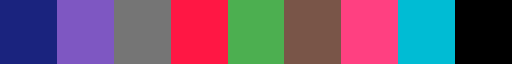

In [ ]:
import matplotlib.gridspec as gridspec
fontsize=13

clrs = np.array(['#1A237E','#7E57C2','#757575','#BDBDBD','#4CAF50','#FF9800','#795548','#FF4081','#00BCD4','#FF1744','#FFFFFF','#000000'])
sys_clrs = ['#E3A19F','#E3BE53','#708090','#90CCA9','#B7522E','#B0E0E6','#A89AC2','#556B2F','#FF6F61','#87CEEB','#FFDAB9','#40E0D0']
cmap_sys = ListedColormap(sys_clrs)
clr_ind =[2,2,8,8,9,9]
# clr2 = [sys_clrs[clr_ind[n]] for n in range(len(clr_ind))]
clr_ind3 = [2,8,9]
clr2b = [sys_clrs[clr_ind3[n]] for n in range(len(clr_ind3))]

clrs_b = clrs[[0,1,2,9,4,6,7,8,11]]
cmap = ListedColormap(clrs)
cmap_b = ListedColormap(clrs_b)
cmap
cmap_b

In [3]:
dataset = 'CalMS21'
base_dir = Path('/data/users/eabe/hypernets/{}/TiDHy_{}/'.format(dataset,dataset))
configs = sorted(list(base_dir.rglob('*config.yaml'))[::2])

for n,conf in enumerate(configs):
    print(n,conf)

0 /data/users/eabe/hypernets/CalMS21/TiDHy_CalMS21/L1ShortWin2/L1_alpha=.001/config.yaml
1 /data/users/eabe/hypernets/CalMS21/TiDHy_CalMS21/L1ShortWin2/L1_alpha=.001,Orth_alpha_r2=5,dataset.train.add_basic_features=False/config.yaml
2 /data/users/eabe/hypernets/CalMS21/TiDHy_CalMS21/L1ShortWin2/L1_alpha=.001,dataset.train.add_basic_features=False/config.yaml
3 /data/users/eabe/hypernets/CalMS21/TiDHy_CalMS21/Temp_large/Orth_alpha_r2=5,dataset.train.add_basic_features=False,mix_dim=20,seed=13/config.yaml
4 /data/users/eabe/hypernets/CalMS21/TiDHy_CalMS21/Temp_large/dataset.train.add_basic_features=False,mix_dim=20/config.yaml
5 /data/users/eabe/hypernets/CalMS21/TiDHy_CalMS21/r2_orth_long/Orth_alpha_r2=5,dataset.train.add_basic_features=False,dataset.train.num_epochs=1500,seed=10/config.yaml
6 /data/users/eabe/hypernets/CalMS21/TiDHy_CalMS21/r2_orth_long/Orth_alpha_r2=5,dataset.train.add_basic_features=False,dataset.train.num_epochs=1500,seed=11/config.yaml
7 /data/users/eabe/hypernets/

In [4]:
n = 3
default_model_config = '/home/eabe/Research/MyRepos/HyperNets/conf/dataset/model/default_model.yaml'
params = OmegaConf.load(default_model_config)
cfg_path =configs[n]# Path('/data/users/eabe/hypernets/SLDS/DPC_SLDS/TestingNoTempLearning/mix_dim=15/config.yaml')
cfg = OmegaConf.load(cfg_path)
for k in cfg.paths.keys():
    cfg.paths[k] = Path(cfg.paths[k])
    cfg.paths[k].mkdir(parents=True, exist_ok=True)
params_curr = cfg.dataset.model
cfg.dataset.model = OmegaConf.merge(params, params_curr)
# cfg.dataset.model['L1_inf_r2'] = 0
# cfg.dataset.model['L1_inf_r'] = 0

In [5]:
# cfg.dataset.train.add_basic_features=False
cfg.dataset.train.normalize=False
data_dict, cfg = load_dataset(cfg)
# ##### Convert to float tensors #####
# test_inputs = torch.tensor(data_dict['inputs_test']).float()
test_inputs = torch.tensor(data_dict['inputs_test']).float()

input_dim = test_inputs.shape[-1]
test_inputs = test_inputs.reshape(-1, cfg.train.sequence_length, input_dim)
cfg.model.input_dim = input_dim

print(f'Our inputs have shape: {test_inputs.shape}')

test_dataset = torch.utils.data.TensorDataset(test_inputs)
dataloader_test = torch.utils.data.DataLoader(test_dataset,batch_size=test_inputs.shape[0],pin_memory=True)
device = torch.device("cuda:{}".format(cfg.train['gpu']) if torch.cuda.is_available() else "cpu")


Creating Dataset: CalMS21
Our inputs have shape: torch.Size([1310, 200, 28])


In [6]:
##### Load weights and params #####
rerecord = False
epoch = 1000
model = TiDHy.TiDHy(cfg.model, device, show_progress=cfg.train.show_progress).to(device)
# set_seed(42)
load_path = cfg.paths.ckpt_dir/'best.pth.tar'
# load_path = sorted(list(cfg.paths.ckpt_dir.rglob('last_{}.pth.tar'.format(epoch))))[0]
data_load = torch.load(load_path,map_location=device)
model.load_state_dict(data_load['state_dict'])
model.to(device)
print('Loaded from {} epoch'.format(data_load['epoch']))
epoch = data_load['epoch']


# result_dict = load_results(model, dataloader_test, data_dict, device, cfg, epoch, rerecord=rerecord)

Loaded from 1001 epoch


/tmp/ipykernel_1769515/2984634.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_load = torch.load(load_path,map_location=device)


In [7]:
seq_len = [100,200,500,1000]

cfg, result_dict = run_seq_len_model(seq_len, model, data_dict, device, epoch, cfg, rerun=False)

data_dict, cfg = load_dataset(cfg)
seq_len = sorted([int(el) for el in list(result_dict.keys())])
seq_len

Creating Dataset: CalMS21


[100, 200, 500, 1000]

In [ ]:
%matplotlib widget

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
p = -1
pca = PCA(n_components=3)
full_state_z = data_dict['annotations_test']
# reg_all = np.concatenate([R2_hat,W,R_bar],axis=1)
X_pca = pca.fit_transform(result_dict['{}'.format(seq_len[p])]['R_hat'])
n = 0
t = 0; dt = len(X_pca)
X_pca = X_pca[t:t+dt]
comps = X_pca[full_state_z==n][t:t+dt]
ax = plt.figure().add_subplot(projection='3d')
# ax = Axes3D(fig)
ax.scatter(comps[:,0],comps[:,1],comps[:,2],c='r',alpha=.75)
ax.scatter(X_pca[:,0],X_pca[:,1],X_pca[:,2],c=clrs_b[p],alpha=.01)
plt.show()

In [ ]:
import plotly.io as pio
import plotly.graph_objects as go
pio.renderers.default = "notebook"


In [ ]:
p = -1
pca = PCA(n_components=3)
full_state_z = data_dict['annotations_test']
# reg_all = np.concatenate([R2_hat,W,R_bar],axis=1)
# X_pca = pca.fit_transform(result_dict['{}'.format(seq_len[p])]['R_hat'])
X_pca = pca.fit_transform(result_dict['{}'.format(seq_len[p])]['R2_hat'])
# X_pca = pca.fit_transform(R_hat)
# X_pca = pca.fit_transform(R_bar)
# X_pca = pca.fit_transform(reg_all)
# X_pca = pca.fit_transform(W[:,np.sum(W,axis=0)!=0])
# X_pca = pca.fit_transform(inputs_train)
# X_pca = pca.fit_transform(b)
# X_pca = pca.fit_transform(Vt.reshape(Vt.shape[0],-1))
n = 3
t = 0; dt = len(X_pca)
fig = go.Figure()
comps = X_pca[full_state_z==n][t:t+dt]
# labels = full_state_z[full_state_z==n]
fig.add_trace(
    go.Scatter3d(
        x=X_pca[:,0], y=X_pca[:,1], z=X_pca[:,2],
        mode='markers',
        marker=dict(
            size=1,
            color='black',                # set color to an array/list of desired values
            colorscale='Viridis',   # choose a colorscale
            opacity=.1
        )
    )
)
fig.add_trace(
    go.Scatter3d(
        x=comps[:,0], y=comps[:,1], z=comps[:,2],
        mode='markers',
        marker=dict(
            size=2,
            color='red',                # set color to an array/list of desired values
            colorscale='Viridis',   # choose a colorscale
            opacity=.01
        )
    )
)


fig.update_layout(
    width=500,
    height=500,
    autosize=False,
)
fig.show()

## Record Testset

In [8]:
save_figs = False
ts=1
W = result_dict['{}'.format(seq_len[ts])]['W'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['W'].shape[-1])
# b = result_dict['{}'.format(seq_len[ts])]['b'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['b'].shape[-1])
I = result_dict['{}'.format(seq_len[ts])]['I'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I'].shape[-1])
Ihat = result_dict['{}'.format(seq_len[ts])]['I_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I_hat'].shape[-1])
R_hat = result_dict['{}'.format(seq_len[ts])]['R_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_hat'].shape[-1])
R_bar = result_dict['{}'.format(seq_len[ts])]['R_bar'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_bar'].shape[-1])
R2_hat = result_dict['{}'.format(seq_len[ts])]['R2_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R2_hat'].shape[-1])
Ut = result_dict['{}'.format(seq_len[ts])]['Ut'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['Ut'].shape[-2],result_dict['{}'.format(seq_len[ts])]['Ut'].shape[-1])
##### Plot dynamic matrices #####
if cfg.model.low_rank_temp:
    Uk = torch.bmm(model.temporal.unsqueeze(-1),model.temporal.unsqueeze(1)).data.cpu().detach()
else:
    Uk = model.temporal.data.cpu().detach().reshape(model.mix_dim,model.r_dim,model.r_dim)
full_state_z = data_dict['annotations_test']


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

reg_variables = [np.concatenate([R2_hat,W,R_hat],axis=-1),R2_hat,W,R_hat,R_bar,I]
labels = ['all','R2_hat','W','R_hat','R_bar','I']

# reg_variables = W
max_acc = 0
tr_batch_size = 40
batch_size = 10
for k,reg_vars in enumerate(reg_variables):

    X_train, X_test, y_train, y_test = train_test_split(reg_vars.reshape(-1,reg_vars.shape[-1]), full_state_z.reshape(-1), test_size=0.25, random_state=42)
    # X_train, X_test, y_train, y_test = train_test_split(reg_vars.reshape(-1,reg_vars.shape[-1]), terrain.reshape(-1), test_size=0.25, random_state=42)
    neigh = KNeighborsClassifier(n_neighbors=3,n_jobs=-1)
    neigh.fit(X_train, y_train)
    scores = neigh.score(X_test, y_test)
    print(labels[k],scores)
    if (scores > max_acc) & (labels[k] != 'I'):
        y_pred = neigh.predict(reg_vars.reshape(-1,reg_vars.shape[-1]))
        max_acc = scores
        best_reg_vars = reg_vars
        best_label = labels[k]
        best_pred = y_pred
    else:
        I_pred = neigh.predict(reg_vars.reshape(-1,reg_vars.shape[-1]))

# plt.imshow(confusion_matrix(full_state_z, best_pred),cmap='viridis')
# plt.colorbar()


all 0.9763969465648855
R2_hat 0.5925648854961832
W 0.23557251908396948
R_hat 0.9763969465648855
R_bar 0.5925648854961832
I 0.9794656488549618


/home/eabe/miniconda3/envs/TiDHy/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:652: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/tmp/ipykernel_1769515/1395090333.py:104: RuntimeWarning: invalid value encountered in divide
  comps = comps/np.max(np.abs(comps),axis=0)
/home/eabe/miniconda3/envs/TiDHy/lib/python3.10/site-packages/numpy/lib/histograms.py:1067: RuntimeWarning: invalid value encountered in divide
  hist /= s
/home/eabe/miniconda3/envs/TiDHy/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/home/eabe/miniconda3/envs/TiDHy/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


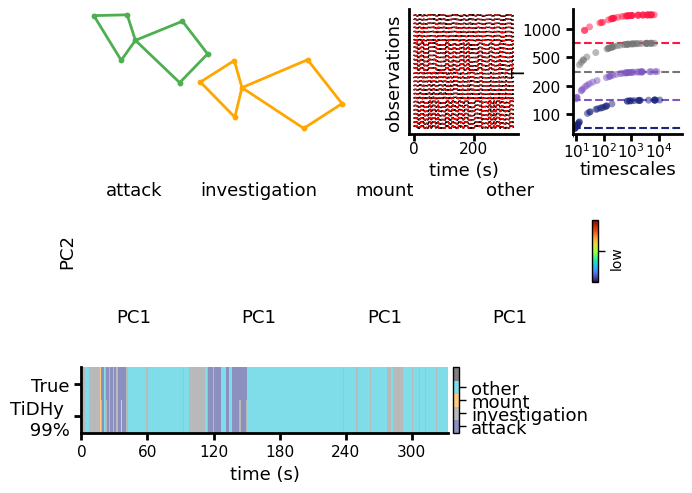

In [10]:
fontsize=13
fps = 30
fig = plt.figure(constrained_layout=True, figsize=(7.75,5.5))
gs  = gridspec.GridSpec(nrows=8, ncols=4,hspace=10,wspace=.5) 
gs0 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[:3,:],  wspace=.5,hspace=.2)
# gsb = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[:3,2:3], wspace=.1,hspace=.5)

# gsc = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[:5,3:], wspace=.5,hspace=.1)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[3:6,:], wspace=.2,hspace=.1)

gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[6:,:-1],   wspace=0, hspace=.10)

##### plotting video frame ######
t = 50; dt = 1
skeleton = np.array([[0,1],[0,2],[2,3],[1,3],[3,4],[3,5],[4,6],[5,6]])
ani1_x = data_dict['inputs_train'][t:t+dt,:7]
ani1_y = data_dict['inputs_train'][t:t+dt,7:14]
ani2_x = data_dict['inputs_train'][t:t+dt,14:21]
ani2_y = data_dict['inputs_train'][t:t+dt,21:28]
I1_x = Ihat[t:t+dt,:7]
I1_y = Ihat[t:t+dt,7:14]
I2_x = Ihat[t:t+dt,14:21]
I2_y = Ihat[t:t+dt,21:28]
labels = data_dict['annotations_train'][t:t+dt]
clrs = plt.get_cmap('tab10',4)
axs = np.array([fig.add_subplot(gs0[:2])])
ax = axs[0]
# ax.imshow(frames[t])
for n in range(7):
    im = ax.scatter(ani1_x[:,n],ani1_y[:,n],s=10,c='#ffa600ff')
    im = ax.scatter(ani2_x[:,n],ani2_y[:,n],s=10,c='#4daf50ff')
tt=0
for n in range(len(skeleton)):
    ax.plot(ani1_x[:,skeleton[n]].squeeze(),ani1_y[:,skeleton[n]].squeeze(),'#ffa600ff',lw=2,zorder=1)
    ax.plot(ani2_x[:,skeleton[n]].squeeze(),ani2_y[:,skeleton[n]].squeeze(),'#4daf50ff',lw=2,zorder=1)
ax.axis('off')

###### Plotting Observations #####
axs = np.array([fig.add_subplot(gs0[2])])
ax = axs[0]
spacing = .75; fontsize=13
t = 0; dt = 10000
hlines,hlines_Ihat= [],[]
for n in range(I.shape[-1]):
    mean_centered = I[t:t+dt,n] - np.mean(I[t:t+dt,n],axis=0)
    mean_centered = mean_centered
    ax.plot(1/fps*np.arange(0,dt,1),mean_centered + n/spacing,color='k', lw=1)
    hlines.append(np.mean(mean_centered + n/spacing,axis=0))
    mean_centered_Ihat = Ihat[t:t+dt,n] - np.mean(Ihat[t:t+dt,n],axis=0)
    ax.plot(1/fps*np.arange(0,dt,1),mean_centered_Ihat + n/spacing,ls='--',color='r', lw=1,zorder=2,label='Pred')
    hlines_Ihat.append(np.mean(mean_centered_Ihat + n/spacing,axis=0))

ax.tick_params(axis='x', labelsize=fontsize-2, pad=0)
ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylabel("observations",fontsize=fontsize)
ax.set_yticks([])

##### Timescales #####
axs = np.array([fig.add_subplot(gs0[3])])
ax = axs[0]
dts = 1/len(seq_len)
y_ranges = np.arange(0,1,(dts*dts)).reshape(-1,len(seq_len))[:,(0,-1)]
for ts in range(len(seq_len)):
    R_bar = result_dict['{}'.format(seq_len[ts])]['R_bar'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_bar'].shape[-1])
    R_hat = result_dict['{}'.format(seq_len[ts])]['R_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_hat'].shape[-1])
    I = result_dict['{}'.format(seq_len[ts])]['I'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I'].shape[-1])

    # ##### Plottign Eigenvalues #####
    Uhat_all = []
    for state in range(len(np.unique(full_state_z))):
        rhat2 = R_hat[np.where(full_state_z==state)[0],:]
        Uhat_0 = np.linalg.inv(rhat2[:-1].T@rhat2[:-1])@rhat2[:-1].T@rhat2[1:]
        Uhat_all.append(Uhat_0)
        
    Uhat_all = np.stack(Uhat_all)
    evals_Uhat_all = np.linalg.eigvals(Uhat_all).reshape(-1)
    timescales = np.real(np.log(evals_Uhat_all))/fps

    ax.scatter(x=1/np.abs(timescales),y=np.abs(evals_Uhat_all)+ts,c=clrs_b[ts],alpha=.5,edgecolor='None',s=25)

for ts in range(len(seq_len)):
    ax.axhline(y=ts,c=clrs_b[ts],linestyle='--',zorder=-1)
#     ax.axvline(x=timescales_M[n],c=sys_clrs[n])
ax.set_yticks([1/2 + q for q in range(len(seq_len))])
ax.set_yticklabels(seq_len,fontsize=fontsize-2)
ax.set_ylabel('T',fontsize=fontsize,labelpad=-5)
# ax.spines.left.set_visible(False)
ax.set_xscale('symlog',linthresh=100)
ax.set_xlabel('timescales',fontsize=fontsize,labelpad=0)
ax.set_xticks([10e0,10e1,10e2,10e3,10e4,10e5])
ax.tick_params(axis='x', labelsize=fontsize-2, pad=0)
ax.set_xlim([-1,7e4])

###### PCA #####
n = 0; m = 1
pca = PCA()
X_pca = pca.fit_transform(R_bar.reshape(-1,R_hat.shape[-1]))
lst = list(itertools.combinations(np.arange(X_pca.shape[-1]), 2))
unq = set(lst)
axs = np.array([fig.add_subplot(gs1[n]) for n in range(4)])
for state in range(4):
    ax = axs[state]
    comps = X_pca[full_state_z==state]
    comps = comps/np.max(np.abs(comps),axis=0)
    # comps = X_pca[(full_state_z==0) | (full_state_z==1) | (full_state_z==2)]
    h,xedge,yedge = np.histogram2d(comps[:,n],comps[:,m],bins=50,range=[[-1,1],[-1,1]],density=True)
    im = ax.imshow((h).T,cmap='turbo',extent=[xedge[0],xedge[-1],yedge[0],yedge[-1]],alpha=1)
    ax.axis('square')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_title('{}'.format(list(data_dict['vocabulary'].keys())[state]),fontsize=fontsize,y=.95)
    ax.set_xlabel('PC{}'.format(n+1),fontsize=fontsize)
    if (state==0):
        ax.set_ylabel('PC{}'.format(m+1),fontsize=fontsize)
ax = axs[-1]
cbar = fig.colorbar(im,ax=axs.flatten(),aspect=10,shrink=.5)
cbar.set_ticks([0,np.max(h)])
cbar.set_ticklabels(['low','high'],rotation=90)
cbar.outline.set_linewidth(1)
cbar.minorticks_off()
cbar.ax.tick_params(width=1,which="major")


##### Behaviroal State ID #####
t = 80000; dt = 10000; 
acc_TiDHy=accuracy_score(best_pred, full_state_z)
# acc_TiDHy=neigh.score(I_pred, full_state_z)
state_compare = np.stack([y_pred,full_state_z],axis=0)
_,norm = map_discrete_cbar(cmap,len(np.unique(full_state_z)))
axs = np.array([fig.add_subplot(gs2[n]) for n in range(1)])
ax = axs[0]
im = ax.pcolormesh(state_compare[:,t:t+dt],cmap=cmap,norm=norm,alpha=.5,rasterized=True)
ax.set_yticks(np.arange(.5,2,1))
ax.set_yticklabels(['TiDHy \n {:02}%'.format(int(np.round(acc_TiDHy*100))),'True'],fontsize=fontsize)
ax.set_xticks(np.arange(0,dt,60*fps))
ax.set_xticklabels((np.arange(0,dt,60*fps)*1/fps).astype(int),fontsize=fontsize-2)
ax.set_xlabel('time (s)',fontsize=fontsize)

# plt.tight_layout()
cbar = fig.colorbar(im,ax=axs.flatten(),aspect=10, pad=.01)

cbar.set_ticks(np.arange(0,len(np.unique(full_state_z)),1))
cbar.set_ticklabels(list(data_dict['vocabulary'].keys()),fontsize=fontsize)
cbar.outline.set_linewidth(1)
cbar.minorticks_off()
cbar.ax.tick_params(width=1,which="major")

# fig.savefig(cfg.paths.fig_dir / 'Fig5.pdf',dpi=300,transparent=True)

In [11]:
import cv2 
 
# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture('/data/users/eabe/hypernets/CalMS21/datasets/mouse001_task1_annotator1.mp4')
 
# Check if camera opened successfully
if (cap.isOpened()== False): 
  print("Error opening video stream or file")
 
# Read until video is completed
frames = []
while(cap.isOpened()):
  # Capture frame-by-frame
  ret, frame = cap.read()
  if ret == True:
    frames.append(frame)   
  # Break the loop
  else: 
    break
 
# When everything done, release the video capture object
cap.release()
 

## Animations

In [ ]:
import ray
import time
import cv2
import gc
mpl.use('agg')


In [ ]:
@ray.remote
def make_plt_im(t, X_pca,data_dict,full_state_z):   #
    trail = 5
    labels = full_state_z[t-trail:t+1]
    cmap = plt.get_cmap('tab10',len(np.unique(full_state_z)))
    bounds = np.arange(len(np.unique(full_state_z))+1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    fig,axs = plt.subplots(1,3,figsize=(15,5))
    ax = axs[0]
    im = ax.scatter(X_pca[:,0],X_pca[:,1],s=1,c='k',alpha=.01)
    im = ax.scatter(X_pca[t-trail:t+1,0],X_pca[t-trail:t+1,1],s=3,c=labels,cmap=cmap,norm=norm,alpha=1)
    ax.axis('square')
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    cbar = fig.colorbar(im, ax=axs,location='right')
    cbar.set_ticks(np.arange(.5,len(np.unique(full_state_z)),1))
    cbar.set_ticklabels(np.arange(-1,len(np.unique(full_state_z))-1,1))
    ax.set_title('Rbar PCA comps')


    ani1_x = data_dict['inputs_test'][t-trail:t+1,:7]
    ani1_y = data_dict['inputs_test'][t-trail:t+1,7:14]
    ani2_x = data_dict['inputs_test'][t-trail:t+1,14:21]
    ani2_y = data_dict['inputs_test'][t-trail:t+1,21:28]
    labels = data_dict['annotations_test'][t-trail:t+1]
    for n in range(7):
        ax = axs[1]
        im = ax.scatter(ani1_x[:,n],ani1_y[:,n],s=1,c=labels,cmap=cmap,norm=norm,)
        ax.axis('square')
        ax.set_xlim([0,1])
        ax.set_ylim([0,1])
        ax.set_title('Mouse 1')
        ax = axs[2]
        ax.scatter(ani2_x[:,n],ani2_y[:,n],s=1,c=labels,cmap=cmap,norm=norm,)
        ax.axis('square')
        ax.set_xlim([0,1])
        ax.set_ylim([0,1])
        ax.set_title('Mouse 2')




    width, height = fig.get_size_inches() * fig.get_dpi()
    fig.canvas.draw()       # draw the canvas, cache the renderer
    images = np.frombuffer(fig.canvas.tostring_rgb(),
                        dtype='uint8').reshape(int(height), int(width), 3)
    plt.close()
    return images

In [ ]:
# images = make_plt_im(t, X_pca,data_dict)
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

# full_state_z = data_dict['annotations_test']
full_state_z = cluster_labels
X_pca = pca.fit_transform(R_bar)

t = 80000; dt = 5000
trail = 5
labels = full_state_z[t-trail:t+1]
cmap = plt.get_cmap('tab10',len(np.unique(full_state_z)))
bounds = np.arange(len(np.unique(full_state_z))+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig,axs = plt.subplots(1,3,figsize=(15,5))
ax = axs[0]
im = ax.scatter(X_pca[:,0],X_pca[:,1],s=1,c='k',alpha=.01)
im = ax.scatter(X_pca[t-trail:t+1,0],X_pca[t-trail:t+1,1],s=3,c=labels,cmap=cmap,norm=norm,alpha=1)
ax.axis('square')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
cbar = fig.colorbar(im, ax=axs,location='right')
cbar.set_ticks(np.arange(.5,len(np.unique(full_state_z)),1))
cbar.set_ticklabels(np.arange(-1,len(np.unique(full_state_z))-1,1))
ax.set_title('Rbar PCA comps')


ani1_x = data_dict['inputs_test'][t-trail:t+1,:7]
ani1_y = data_dict['inputs_test'][t-trail:t+1,7:14]
ani2_x = data_dict['inputs_test'][t-trail:t+1,14:21]
ani2_y = data_dict['inputs_test'][t-trail:t+1,21:28]
labels = data_dict['annotations_test'][t-trail:t+1]
for n in range(7):
    ax = axs[1]
    im = ax.scatter(ani1_x[:,n],ani1_y[:,n],s=1,c=labels,cmap=cmap,norm=norm,)
    ax.axis('square')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_title('Mouse 1')
    ax = axs[2]
    ax.scatter(ani2_x[:,n],ani2_y[:,n],s=1,c=labels,cmap=cmap,norm=norm,)
    ax.axis('square')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_title('Mouse 2')




fig.savefig(cfg.paths.fig_dir/'test.png',dpi=300)


In [ ]:
np.where(cluster_labels==2)[0].shape

In [ ]:
start = time.time()
##### initialize time points for animation and progressbar #####
t = 0 ; dt = 10000
full_state_z = cluster_labels
state = 'I'
time_range = np.arange(t,t+dt)#  np.where(cluster_labels==state)[0]#
num_ticks = np.size(time_range)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(I)

##### Put large arrays into shared memory #####
X_pca_r = ray.put(X_pca)
data_dict_r = ray.put(data_dict)
full_state_z_r = ray.put(full_state_z)
##### Loop over parameters appending process ids #####
result_ids = []
for t in time_range:
    result_ids.append(make_plt_im.remote(t, X_pca_r, data_dict_r,full_state_z_r))

##### pring progressbar and get results #####
results_p = ray.get(result_ids)
images = np.stack([results_p[i] for i in range(len(results_p))])

##### Make video with opencv #####
aniname = 'PCA_Evolve_{}.mp4'.format(state) 


vid_name = cfg.paths.fig_dir / aniname
FPS = 30
out = cv2.VideoWriter(vid_name.as_posix(), cv2.VideoWriter_fourcc(*'mp4v'), FPS, (images.shape[-2], images.shape[-3]))

for fm in tqdm(range(images.shape[0])):
    out.write(cv2.cvtColor(images[fm], cv2.COLOR_BGR2RGB))
out.release()
print('Making Animation {}: {}'.format(aniname, time.time()-start))
del results_p, X_pca_r, data_dict_r, full_state_z_r
gc.collect()



In [ ]:
t = 80000 ; dt = 5000
labels = full_state_z[t:t+dt]
cmap = plt.get_cmap('tab10',len(np.unique(full_state_z)))
bounds = np.arange(len(np.unique(full_state_z))+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig,axs = plt.subplots(1,3,figsize=(15,5))
ax = axs[0]
im = ax.scatter(X_pca[t:t+dt,0],X_pca[t:t+dt,1],s=1,c=labels,cmap=cmap,norm=norm,alpha=1)
ax.axis('square')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
cbar = fig.colorbar(im, ax=axs,location='right')
cbar.set_ticks(np.arange(.5,4,1))
cbar.set_ticklabels(list(data_dict['vocabulary'].keys()))
ax.set_title('Rbar PCA comps')


ani1_x = data_dict['inputs_test'][t:t+dt,:7]
ani1_y = data_dict['inputs_test'][t:t+dt,7:14]
ani2_x = data_dict['inputs_test'][t:t+dt,14:21]
ani2_y = data_dict['inputs_test'][t:t+dt,21:28]
labels = data_dict['annotations_test'][t:t+dt]
clrs = plt.get_cmap('tab10',4)
for n in range(7):
    ax = axs[1]
    im = ax.scatter(ani1_x[:,n],ani1_y[:,n],s=1,c=labels,cmap=clrs)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.axis('square')
    ax.set_title('Mouse 1')
    ax = axs[2]
    ax.scatter(ani2_x[:,n],ani2_y[:,n],s=1,c=labels,cmap=clrs)
    ax.axis('square')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_title('Mouse 2')
